In [18]:
# pytorch requirements
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

# other requirements
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
import pandas as pd

import os
import random

# custom
#from utils import set_all_seeds, load_dataset
#from config import Config

#-----------------------------
%matplotlib inline

In [19]:
def gpu_info():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.device_count())
gpu_info()

GeForce GTX 1080 Ti
1


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
#----------utilities---------------------
# loading the dataset------------------------------------------
def load_dataset(batch_size):
    # loading the MNIST dataset
    train_set = datasets.MNIST(root = 'data', train = True, download = True, transform = transforms.ToTensor())
    test_set = datasets.MNIST(root = 'data', train = False, download = True, transform = transforms.ToTensor())

    # Setting up the dataloaders
    train_dataloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)
    
    return train_dataloader, test_dataloader
    
    
# setting random seeds-----------------------------------------
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [22]:
class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers):
        super(VRNN, self).__init__()
        
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers
        
        # feature extractions
        # extracting features of the input x<t> 
        self.phi_x = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU()
        )
        
        # extracting features of the the latent variable z<t>
        self.phi_z = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU()
        )
        
        # encoder
        self.encoder = nn.Sequential(
            #nn.Linear(h_dim + h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(2*h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.encoder_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
        )
        
        self.encoder_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.Softplus()
        )
        
        # prior distribution and its parameters
        self.prior = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.prior_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim)
        )
        
        self.prior_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.Softplus()
        )
        
        # decoder
        self.decoder = nn.Sequential(
            #nn.Linear(h_dim + h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(2*h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.decoder_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Sigmoid()
        )
        self.decoder_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Softplus()
        )
        
        # recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers)
        #self.rnn = nn.LSTM(h_dim + h_dim, h_dim, n_layers)
        
        
    def inference(self, phi_x_t, ht_minus_1):
        
        # returns the parameters of the posterior distribution
        
        encoder_input = torch.cat([phi_x_t, ht_minus_1], dim=1)
        encoder_t = self.encoder(encoder_input)
        encoder_mean_t = self.encoder_mean(encoder_t)
        encoder_var_t = self.encoder_var(encoder_t)
        
        return encoder_mean_t, encoder_var_t
    
    
    def generation_z(self, ht_minus_1):
        
        # returns the parameters of the prior distribution
        
        prior_t = self.prior(ht_minus_1)
        prior_mean_t = self.prior_mean(prior_t)
        prior_var_t = self.prior_var(prior_t)
        
        return prior_mean_t, prior_var_t
    
    
    def generation_x(self, phi_z_t, ht_minus_1):
        
        # returns the parameters of the output distribution
        
        decoder_input = torch.cat([phi_z_t, ht_minus_1], dim=1)
        decoder_t = self.decoder(decoder_input)
        decoder_mean_t = self.decoder_mean(decoder_t)
        decoder_var_t = self.decoder_var(decoder_t)
        
        return decoder_mean_t, decoder_var_t
    
    
    def recurrence(self, phi_x_t, phi_z_t, h, c=0):
        
        rnn_input = torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0)
        _, h = self.rnn(rnn_input, h) # gru
        #_, (h,c) = self.rnn(rnn_input, (h,c)) # lstm
        
        return h
    
    
    def reparameterize(self, *args):
        z_mean, z_log_var = args
        
        # sampling from a standard normal distribution
        #eps = torch.randn(z_mean.size(0), z_mean.size(1)).to(device)
        
        # creating a random variable z drawn from a normal distribution having parameters z_mu and z_log_var
        #z = z_mean + eps*torch.exp(z_log_var/2.)

        eps = torch.FloatTensor(z_log_var.size()).normal_().to(device)
        return eps.mul(z_log_var).add_(z_mean)
        #return z

    
    
    def forward(self, x):
        
        all_encoder_mean, all_encoder_var = [], []
        all_prior_mean, all_prior_var = [], []
        all_decoder_mean, all_decoder_var = [], []
        
        timesteps = x.size(1) # timesteps = 28  (x is of shape = (batch_size, 28, 28))
        h = torch.zeros([self.n_layers, x.size(0), self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        #c = torch.zeros([self.n_layers, x.size(0), self.h_dim], device = x.device) # cell state if using lstm
        
        for t in range(timesteps):
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[:, t, :])   # x[:, t, :] has dimensions (batch_size, 28)
        
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, decoder_var_t = self.generation_x(phi_z_t, h[-1])
            #print("decoder mean vector size: ",decoder_mean_t.size())  # (batch_size, 28)
                
            # prior
            prior_mean_t, prior_var_t = self.generation_z(h[-1]) # gru
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h)
            
            all_encoder_mean.append(encoder_mean_t)
            all_encoder_var.append(encoder_var_t)
            all_prior_mean.append(prior_mean_t)
            all_prior_var.append(prior_var_t)
            all_decoder_mean.append(decoder_mean_t)
            all_decoder_var.append(decoder_var_t)
            
        return [all_encoder_mean, all_encoder_var, all_prior_mean, all_prior_var, all_decoder_mean, all_decoder_var]
    
    
    # To sample from the prior distribution
    def sample(self, seq_len, device, get_latent_vector = False):
        
        sample = torch.zeros(seq_len, self.x_dim, device = device)
        h = torch.zeros(self.n_layers, 1, self.h_dim, device = device)
        #c = torch.zeros(self.n_layers, 1, self.h_dim, device = device) # cell state if using lstm
        
        if get_latent_vector == True:
            z = torch.zeros(seq_len, self.z_dim, device = device)
        
        for t in range(seq_len):
            
            # prior
            prior_mean_t, prior_var_t = self.generation_z(h[-1])
            
            # reparameterization
            z_t = self.reparameterize(prior_mean_t, prior_var_t)
             
            # stacking the latent vectors into a matrix 
            if get_latent_vector == True:
                z[t] = z_t.data
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, _ = self.generation_x(phi_z_t, h[-1])
            
            # sampling the x_t (the reconstructed output)
            #x_t = self.reparameterize(decoder_mean_t, decoder_var_t)
            
            #phi_x_t = self.phi_x(x_t)
            phi_x_t = self.phi_x(decoder_mean_t)
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h) # gru
            
            #print(x_t.data)
            sample[t] = decoder_mean_t.data
            #sample[t] = x_t.data
            
        if get_latent_vector == True:
            return sample, z
        return sample
    
 
    # To encode the th given input into it's latent representation
    def encode(self, x):
        
        timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
        h = torch.zeros([self.n_layers, 1, self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        
        z = torch.zeros(timesteps, self.z_dim, device = x.device)
        
        for t in range(timesteps):    
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            z[t] = z_t.data
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h) # gru
            
        return z
    
    
    # for reconstructing the output from the given input by samping latent vector from posterior distribution
    def reconstruction_from_posterior(self, x):
        
        timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
        h = torch.zeros([self.n_layers, 1, self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        
        seq_len = x.size(1)
        sample_post = torch.zeros(seq_len, self.x_dim, device = x.device)
        
        for t in range(timesteps):
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, decoder_var_t = self.generation_x(phi_z_t, h[-1])
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h)
            
            sample_post[t] = decoder_mean_t.data
            
        return sample_post
            

In [ ]:
import torch
import torch.distributions.normal as Norm
import torch.distributions.kl as KL
import torch.nn.functional as F
import numpy as np

In [ ]:
class Losses:
    def __init__(self, device):
        self.small = torch.tensor([1e-10]).to(device)
    
    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        kld_element =  (2 * torch.log(torch.max(std_2,self.small)) - 2 * torch.log(torch.max(std_1,self.small)) + (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /(std_2.pow(2)+1e-10) - 1)
        return 0.5 * torch.sum(kld_element)    
    
    def KLD_loss(mean_1, std_1, mean_2, std_2):
        ret = -0.5 * torch.sum(std_1 - std_2 - torch.div(std_1.exp() + (mean_1 - mean_2).pow(2), std_2.exp()+1e-10))
        return ret
    
    def kl_type_1(self, mean_1, std_1, mean_2, std_2):
        KL_loss = self._kld_gauss(mean_1, std_1, mean_2, std_2)
        return KL_loss
    
    def kl_type_2(self, mean_1, std_1, mean_2, std_2):
        norm_dist_1 = Norm.Normal(mean_1, std_1)
        norm_dist_2 = Norm.Normal(mean_2, std_2)
        KL_loss = torch.mean(KL.kl_divergence(norm_dist_2, norm_dist_1))
        return KL_loss
    
    def kl_type_3(self, mean_1, std_1, mean_2, std_2):
        KL_loss = self.KLD_loss(mean_1, std_1, mean_2, std_2)
        return KL_loss
    
    def _nll_bernoulli(self, x, theta):
        return - torch.sum(x*torch.log(torch.max(theta, self.small)) + (1-x)*torch.log(torch.max(1-theta, self.small)))
    
    def Gaussian_nll(self, y, mu, sig):
        #nll = 0.5 * torch.sum(torch.square(y - mu) / sig**2 + 2 * torch.log(sig) + torch.log(torch.tensor(2 * np.pi)), axis=-1)
        nll = 0.5 * torch.sum(torch.square(y - mu) / (sig**2+1e-10) + 2 * torch.log(torch.max(sig,self.small)) + torch.log(torch.tensor(2 * np.pi)))
        return nll
    
    def recons_type_1(self, x, theta):
        recons_loss = _nll_bernoulli(x, theta)
        return recons_loss
    
    def recons_type_2(self, x, theta):
        recons_loss = torch.mean(F.binary_cross_entropy(theta, x, reduction = 'none'))
        return recons_loss
    
    def recons_type_3(self, y, mu, sig):
        recons_loss = Gaussian_nll(y, mu, sig)
        #recons_loss = torch.mean(recons_loss) # when axis axis=-1 in Gaussian_nll
        return recons_loss 

In [ ]:
losses = Losses(device)

In [ ]:
def loss_function(dist_params, x):
    
    encoder_mean, encoder_var, prior_mean, prior_var, decoder_mean, decoder_var = dist_params
    loss = 0.
    KL_loss_=0.
    recons_loss_=0.
    
    timesteps = x.size(1)
    
    for t in range(timesteps):
        
        # KL loss-------------------------------------------------------------------------------
        
        KL_loss = losses.kl_type_1(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        #KL_loss = losses.kl_type_2(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        #KL_loss = losses.kl_type_3(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        
        # reconstruction loss-------------------------------------------------------------------
        
        recons_loss = losses.recons_type_1(x[:, t, :], decoder_mean[t])
        #recons_loss = losses.recons_type_2(x[:, t, :], decoder_mean[t])
        #recons_loss = losses.recons_type_3(x[:, t, :], decoder_mean[t], decoder_var[t])
        
        #------------------------------------------------------------------------------------------
        loss += recons_loss + KL_loss
        KL_loss_+=KL_loss
        recons_loss_+=recons_loss
    
    return loss, KL_loss_, recons_loss_

In [28]:
# Class for Early Stopping--------------------------------------
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='saves/checkpoint3.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [29]:

def train(model, train_dataloader, conf, epoch, device):
   
    model.train()
    size = len(train_dataloader.dataset)
    train_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_dataloader):
        x = x.to(device)
        x = x.squeeze()   # x is of dimensions (batch_size, 1, 28, 28) --> after squeezing --> (batch_size, 28, 28)
        #x /= 255
        x = (x - x.min().item()) / (x.max().item() - x.min().item())
        
        #----------------forward----------------------
        dist_params = model(x)
        loss, kl_loss, recons_loss = loss_function(dist_params, x)
        train_loss += loss.item()
        
        
        #------------backward------------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _ = nn.utils.clip_grad_norm_(model.parameters(), conf.clip)
        
        # ----------logging---------------
        if batch_idx % conf.print_every == 0:
            current = batch_idx*len(x)
            loss = loss.item()
            print(f"loss: {loss/conf.batch_size:>7f}  [{current:>5d}/{size:>5d}]") 
            print(f"KL_loss: {kl_loss.item()/conf.batch_size:.6f}, recons_loss: {recons_loss.item()/conf.batch_size:.6f}")
            
            # generating samples
            sample = model.sample(conf.x_dim, device)
            #print(z.size())
            #print(z)
            #fig = plt.figure(figsize=(5,5))
            #fig.add_subplot(1,2,1)
            plt.imshow(sample.cpu().detach().numpy())
            #plt.imshow(z.cpu().detach().numpy())
            plt.pause(1e-6)
            #plt.pause(1e-6)
            
        #break
    
    avg_train_loss = train_loss/size  # average training loss per epoch
    print('====> Average Train loss: {:.4f}'.format(avg_train_loss))
    
    return avg_train_loss
        

In [30]:
def test(model, test_dataloader, conf, epoch, device):
    
    model.eval()
    size = len(test_dataloader.dataset)
    test_loss = 0
    
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_dataloader):
            x = x.to(device)
            x = x.squeeze()
            #x /= 255
            x = (x - x.min().item()) / (x.max().item() - x.min().item())
        
            #-------forward----------------
            dist_params = model(x)
            loss,_,_ = loss_function(dist_params, x)
            
            '''
            if batch_idx % conf.print_every == 0:
                sample, z = model.sample(conf.x_dim, device)
                plt.imshow(sample.cpu().detach().numpy())
                plt.pause(1e-6)
            '''
            
            test_loss += loss.item()
    
    #--------logging-----------------
    avg_test_loss = test_loss/size  # average test loss per epoch
    print('====> Average Test loss: {:.4f}'.format(avg_test_loss))
    
    return avg_test_loss
        

In [31]:
def execute(model, train_dataoader, test_dataloader, conf, device):

    train_loss = []  # list of training losses for all epochs
    test_loss = []   # list of test losses for all epochs
    
    # instantiating the object of EarlyStopping class 
    early_stopping = EarlyStopping(patience=conf.patience, verbose=True)
    
    for ep in range(1, conf.n_epochs+1):
        
        print(f"Epoch {ep}\n-------------------------------")
        train_loss_per_epoch = train(model, train_dataloader, conf, ep, device)
        
        #break
        
        test_loss_per_epoch = test(model, test_dataloader, conf, ep, device)
        
        train_loss.append(train_loss_per_epoch)
        test_loss.append(test_loss_per_epoch)
        
        # saving model without early stopping
        """
        if ep % conf.save_every == 1:
            fn = 'saves/vrnn_state_dict_'+str(ep)+'.pt'
            torch.save(model.state_dict(), fn)
            print('Saved model to '+fn)
        """
        
        # early_stopping needs the validation/test loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(test_loss_per_epoch, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('saves/checkpoint3.pt'))
        
    print("Execution complete")
    
    return model, train_loss, test_loss

In [32]:
# configuration class for hyperparameters and other small things
class Config(object):
    
    def __init__(self):
        
        # hyperparameters
        self.x_dim = 28
        self.h_dim = 100
        self.z_dim = 16
        self.n_layers = 1
        self.n_epochs = 100
        self.clip = 10
        self.batch_size = 128
        self.learning_rate = 0.0001
        self.patience = 5
        
        # other
        self.print_every = 100
        self.save_every = 10
        self.seed = 123
        self.device_ids = [0,1,2,3]

Epoch 1
-------------------------------
loss: 553.415039  [    0/60000]
KL_loss: 8.693549, recons_loss: 544.721558


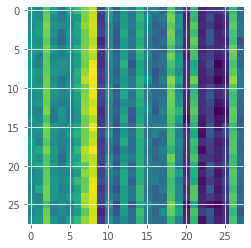

loss: 314.692535  [12800/60000]
KL_loss: 0.447780, recons_loss: 314.244720


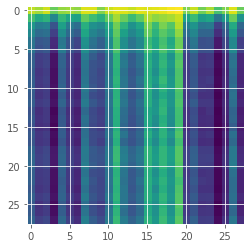

loss: 245.614624  [25600/60000]
KL_loss: 1.045293, recons_loss: 244.569321


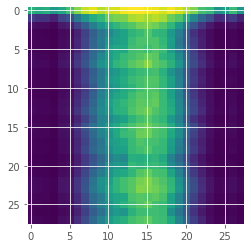

loss: 226.744492  [38400/60000]
KL_loss: 8.244731, recons_loss: 218.499756


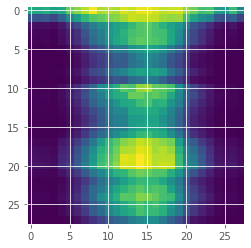

loss: 201.900848  [51200/60000]
KL_loss: 7.038515, recons_loss: 194.862350


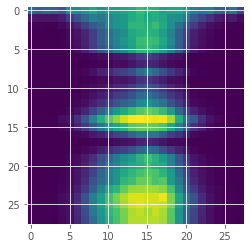

====> Average Train loss: 286.8657
====> Average Test loss: 190.4472
Validation loss decreased (inf --> 190.447209).  Saving model ...
Epoch 2
-------------------------------
loss: 189.453369  [    0/60000]
KL_loss: 5.458872, recons_loss: 183.994476


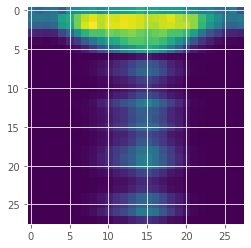

loss: 183.083618  [12800/60000]
KL_loss: 3.977395, recons_loss: 179.106201


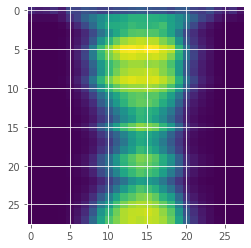

loss: 163.581070  [25600/60000]
KL_loss: 2.798271, recons_loss: 160.782806


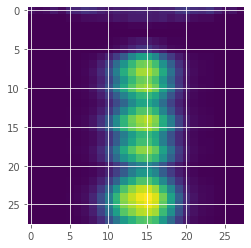

loss: 165.734238  [38400/60000]
KL_loss: 2.417849, recons_loss: 163.316360


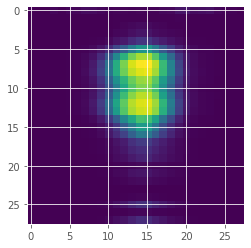

loss: 155.394363  [51200/60000]
KL_loss: 1.796438, recons_loss: 153.597946


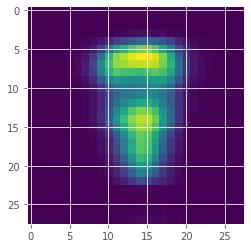

====> Average Train loss: 167.6620
====> Average Test loss: 152.0836
Validation loss decreased (190.447209 --> 152.083551).  Saving model ...
Epoch 3
-------------------------------
loss: 146.340622  [    0/60000]
KL_loss: 1.858895, recons_loss: 144.481766


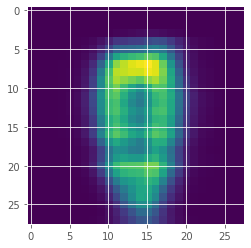

loss: 150.797974  [12800/60000]
KL_loss: 1.998921, recons_loss: 148.799042


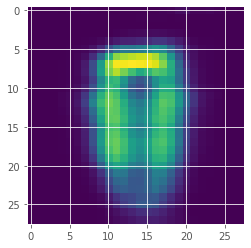

loss: 139.556030  [25600/60000]
KL_loss: 2.221230, recons_loss: 137.334778


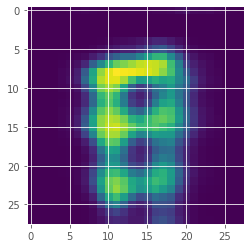

loss: 127.085121  [38400/60000]
KL_loss: 2.518755, recons_loss: 124.566353


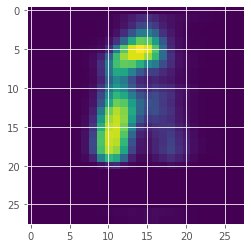

loss: 120.971390  [51200/60000]
KL_loss: 2.518937, recons_loss: 118.452446


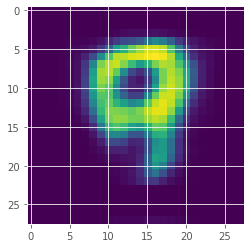

====> Average Train loss: 135.3877
====> Average Test loss: 115.1135
Validation loss decreased (152.083551 --> 115.113480).  Saving model ...
Epoch 4
-------------------------------
loss: 115.685806  [    0/60000]
KL_loss: 2.582987, recons_loss: 113.102814


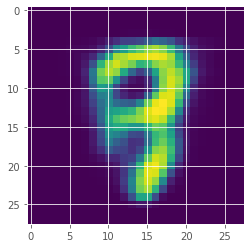

loss: 113.557663  [12800/60000]
KL_loss: 2.589174, recons_loss: 110.968498


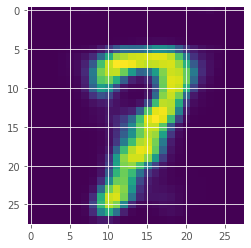

loss: 107.169128  [25600/60000]
KL_loss: 2.445351, recons_loss: 104.723785


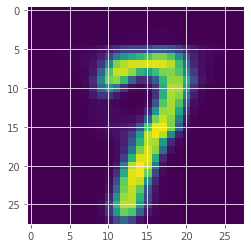

loss: 104.446350  [38400/60000]
KL_loss: 2.651666, recons_loss: 101.794701


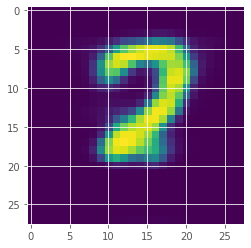

loss: 105.697144  [51200/60000]
KL_loss: 2.835371, recons_loss: 102.861763


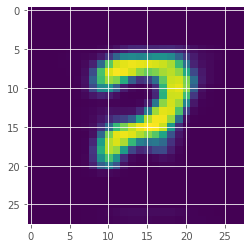

====> Average Train loss: 108.5474
====> Average Test loss: 102.3204
Validation loss decreased (115.113480 --> 102.320437).  Saving model ...
Epoch 5
-------------------------------
loss: 100.120064  [    0/60000]
KL_loss: 2.650255, recons_loss: 97.469795


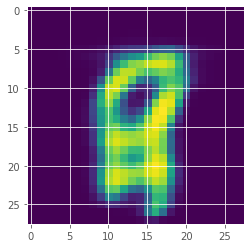

loss: 101.889526  [12800/60000]
KL_loss: 2.786714, recons_loss: 99.102814


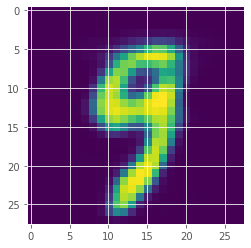

loss: 101.432518  [25600/60000]
KL_loss: 2.553150, recons_loss: 98.879356


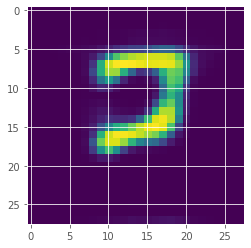

loss: 99.821342  [38400/60000]
KL_loss: 2.781571, recons_loss: 97.039757


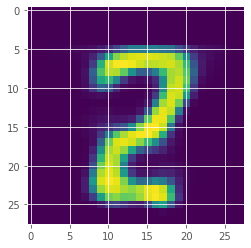

loss: 96.763603  [51200/60000]
KL_loss: 2.771201, recons_loss: 93.992393


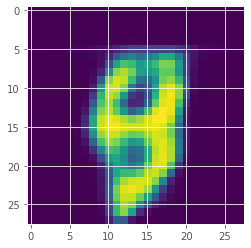

====> Average Train loss: 101.1434
====> Average Test loss: 97.5727
Validation loss decreased (102.320437 --> 97.572739).  Saving model ...
Epoch 6
-------------------------------
loss: 96.952965  [    0/60000]
KL_loss: 2.863926, recons_loss: 94.089035


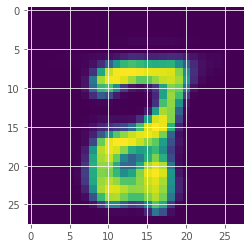

loss: 95.271812  [12800/60000]
KL_loss: 2.763926, recons_loss: 92.507889


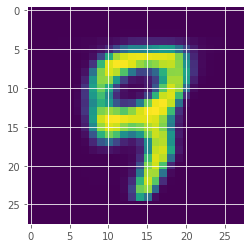

loss: 101.157669  [25600/60000]
KL_loss: 3.038703, recons_loss: 98.118958


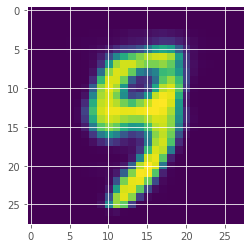

loss: 95.628838  [38400/60000]
KL_loss: 2.566603, recons_loss: 93.062218


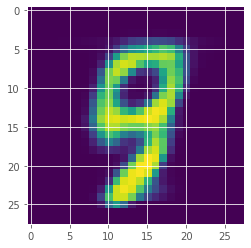

loss: 94.285683  [51200/60000]
KL_loss: 2.718579, recons_loss: 91.567108


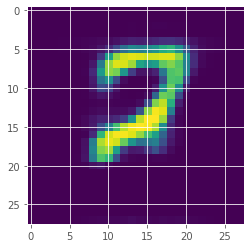

====> Average Train loss: 97.3597
====> Average Test loss: 94.6487
Validation loss decreased (97.572739 --> 94.648727).  Saving model ...
Epoch 7
-------------------------------
loss: 93.572838  [    0/60000]
KL_loss: 2.364936, recons_loss: 91.207893


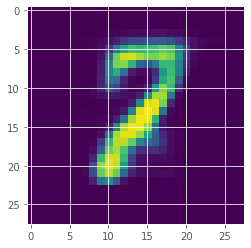

loss: 96.858238  [12800/60000]
KL_loss: 2.654404, recons_loss: 94.203842


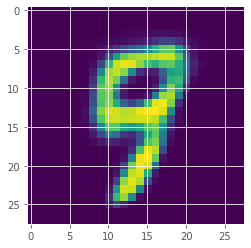

loss: 91.042061  [25600/60000]
KL_loss: 2.531637, recons_loss: 88.510406


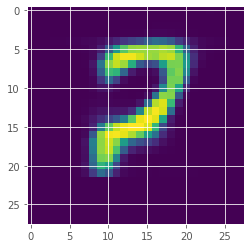

loss: 90.030983  [38400/60000]
KL_loss: 2.413185, recons_loss: 87.617798


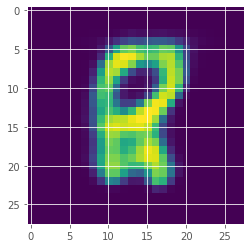

loss: 94.287910  [51200/60000]
KL_loss: 2.548429, recons_loss: 91.739471


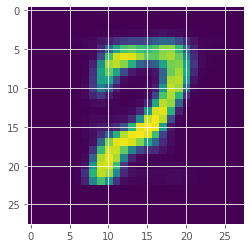

====> Average Train loss: 94.8561
====> Average Test loss: 92.5863
Validation loss decreased (94.648727 --> 92.586336).  Saving model ...
Epoch 8
-------------------------------
loss: 91.114548  [    0/60000]
KL_loss: 2.513476, recons_loss: 88.601059


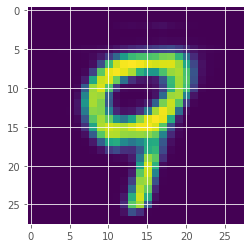

loss: 93.839073  [12800/60000]
KL_loss: 2.499474, recons_loss: 91.339600


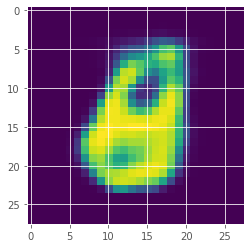

loss: 88.690308  [25600/60000]
KL_loss: 2.430161, recons_loss: 86.260155


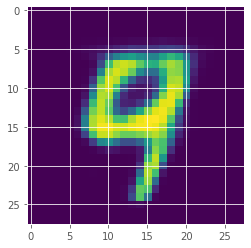

loss: 90.569099  [38400/60000]
KL_loss: 2.542226, recons_loss: 88.026886


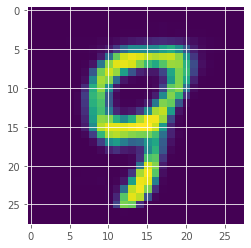

loss: 91.987900  [51200/60000]
KL_loss: 2.492534, recons_loss: 89.495377


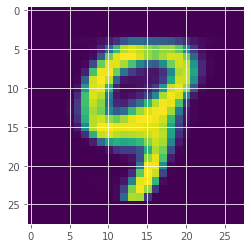

====> Average Train loss: 93.0342
====> Average Test loss: 90.9797
Validation loss decreased (92.586336 --> 90.979695).  Saving model ...
Epoch 9
-------------------------------
loss: 95.031990  [    0/60000]
KL_loss: 2.779186, recons_loss: 92.252823


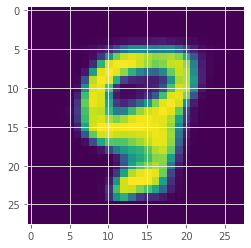

loss: 90.398499  [12800/60000]
KL_loss: 2.590107, recons_loss: 87.808388


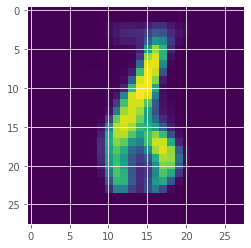

loss: 90.950981  [25600/60000]
KL_loss: 2.739831, recons_loss: 88.211151


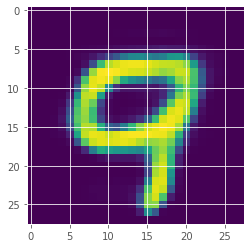

loss: 89.779770  [38400/60000]
KL_loss: 2.322158, recons_loss: 87.457619


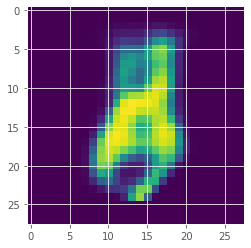

loss: 86.620567  [51200/60000]
KL_loss: 2.293009, recons_loss: 84.327530


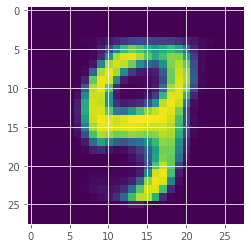

====> Average Train loss: 91.6433
====> Average Test loss: 89.8532
Validation loss decreased (90.979695 --> 89.853192).  Saving model ...
Epoch 10
-------------------------------
loss: 90.644577  [    0/60000]
KL_loss: 2.382372, recons_loss: 88.262192


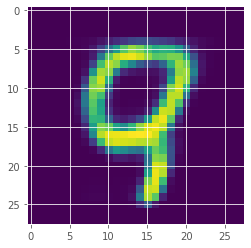

loss: 92.731415  [12800/60000]
KL_loss: 2.739094, recons_loss: 89.992340


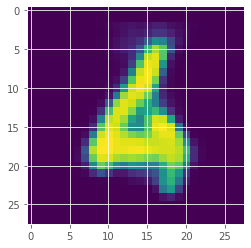

loss: 91.709015  [25600/60000]
KL_loss: 2.582369, recons_loss: 89.126648


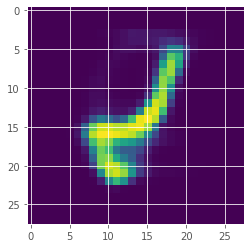

loss: 89.777176  [38400/60000]
KL_loss: 2.804645, recons_loss: 86.972534


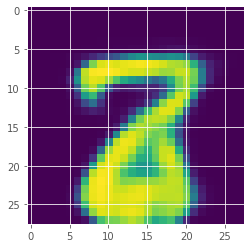

loss: 90.900391  [51200/60000]
KL_loss: 2.788221, recons_loss: 88.112175


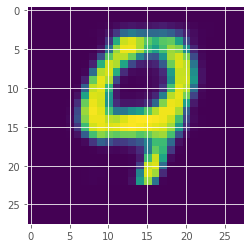

====> Average Train loss: 90.5175
====> Average Test loss: 88.8379
Validation loss decreased (89.853192 --> 88.837907).  Saving model ...
Epoch 11
-------------------------------
loss: 91.755119  [    0/60000]
KL_loss: 2.590539, recons_loss: 89.164566


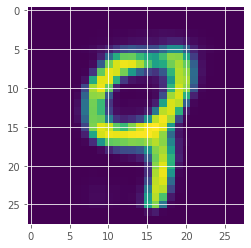

loss: 92.210442  [12800/60000]
KL_loss: 2.563364, recons_loss: 89.647079


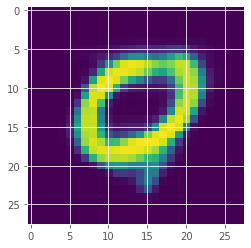

loss: 89.279732  [25600/60000]
KL_loss: 2.427087, recons_loss: 86.852638


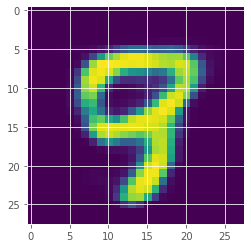

loss: 91.472481  [38400/60000]
KL_loss: 2.586732, recons_loss: 88.885735


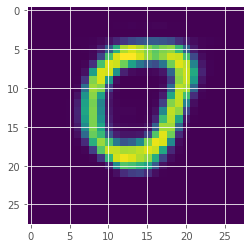

loss: 87.797737  [51200/60000]
KL_loss: 2.365135, recons_loss: 85.432602


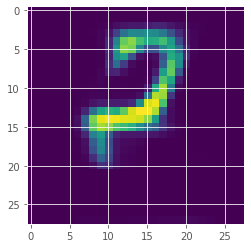

====> Average Train loss: 89.5434
====> Average Test loss: 87.9886
Validation loss decreased (88.837907 --> 87.988564).  Saving model ...
Epoch 12
-------------------------------
loss: 88.781158  [    0/60000]
KL_loss: 2.519546, recons_loss: 86.261612


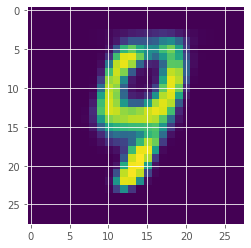

loss: 90.631500  [12800/60000]
KL_loss: 2.391283, recons_loss: 88.240211


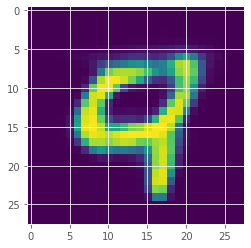

loss: 89.665176  [25600/60000]
KL_loss: 2.491738, recons_loss: 87.173439


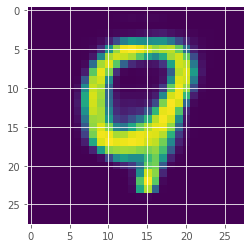

loss: 84.253181  [38400/60000]
KL_loss: 2.337954, recons_loss: 81.915230


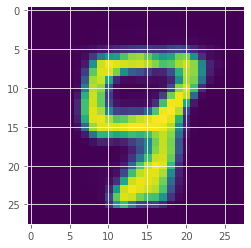

loss: 91.682968  [51200/60000]
KL_loss: 2.476267, recons_loss: 89.206718


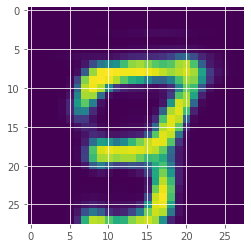

====> Average Train loss: 88.7047
====> Average Test loss: 87.1641
Validation loss decreased (87.988564 --> 87.164114).  Saving model ...
Epoch 13
-------------------------------
loss: 87.114929  [    0/60000]
KL_loss: 2.531774, recons_loss: 84.583176


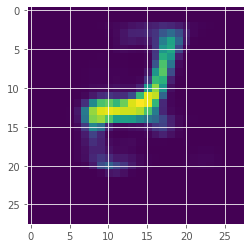

loss: 91.033897  [12800/60000]
KL_loss: 2.551449, recons_loss: 88.482475


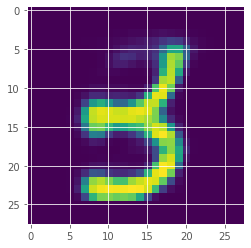

loss: 90.547386  [25600/60000]
KL_loss: 2.769028, recons_loss: 87.778366


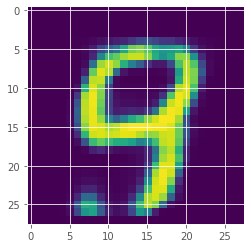

loss: 88.282890  [38400/60000]
KL_loss: 2.457257, recons_loss: 85.825638


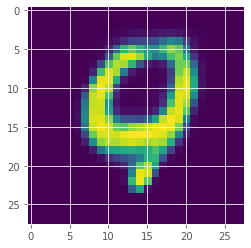

loss: 88.443069  [51200/60000]
KL_loss: 2.701657, recons_loss: 85.741417


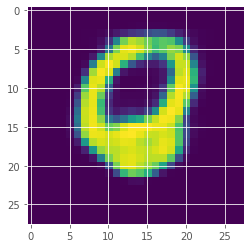

====> Average Train loss: 88.0031
====> Average Test loss: 87.0722
Validation loss decreased (87.164114 --> 87.072174).  Saving model ...
Epoch 14
-------------------------------
loss: 90.250687  [    0/60000]
KL_loss: 2.556015, recons_loss: 87.694664


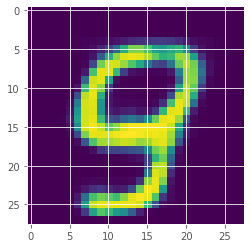

loss: 90.048615  [12800/60000]
KL_loss: 2.917230, recons_loss: 87.131363


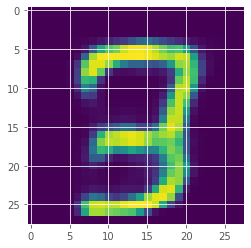

loss: 86.060234  [25600/60000]
KL_loss: 2.419832, recons_loss: 83.640419


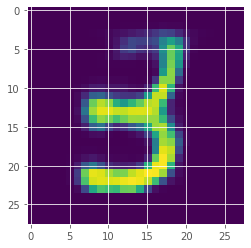

loss: 85.861328  [38400/60000]
KL_loss: 2.855271, recons_loss: 83.006058


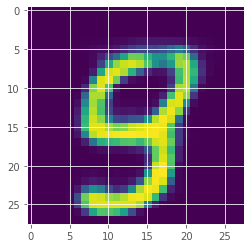

loss: 85.353241  [51200/60000]
KL_loss: 2.375047, recons_loss: 82.978203


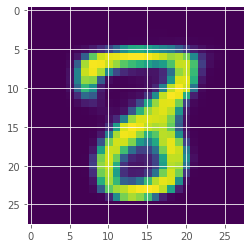

====> Average Train loss: 87.3825
====> Average Test loss: 85.9899
Validation loss decreased (87.072174 --> 85.989906).  Saving model ...
Epoch 15
-------------------------------
loss: 86.100304  [    0/60000]
KL_loss: 2.482027, recons_loss: 83.618279


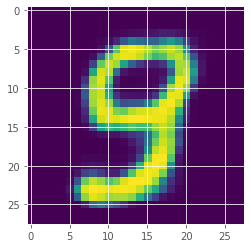

loss: 89.323074  [12800/60000]
KL_loss: 2.625261, recons_loss: 86.697815


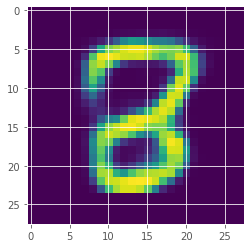

loss: 86.239349  [25600/60000]
KL_loss: 2.693810, recons_loss: 83.545532


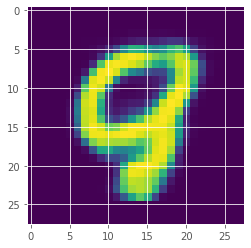

loss: 88.752876  [38400/60000]
KL_loss: 2.594307, recons_loss: 86.158592


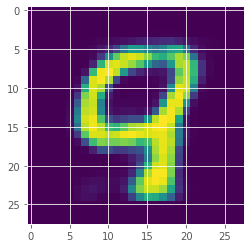

loss: 86.158669  [51200/60000]
KL_loss: 2.504795, recons_loss: 83.653877


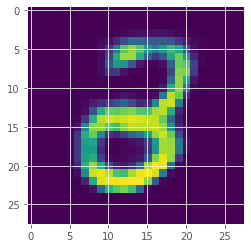

====> Average Train loss: 86.8243
====> Average Test loss: 85.5027
Validation loss decreased (85.989906 --> 85.502719).  Saving model ...
Epoch 16
-------------------------------
loss: 85.563339  [    0/60000]
KL_loss: 2.584937, recons_loss: 82.978409


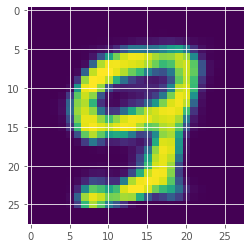

loss: 86.097839  [12800/60000]
KL_loss: 2.707700, recons_loss: 83.390129


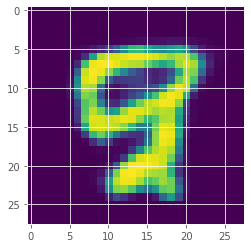

loss: 88.907242  [25600/60000]
KL_loss: 2.599196, recons_loss: 86.308052


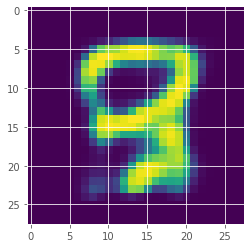

loss: 85.598129  [38400/60000]
KL_loss: 2.501845, recons_loss: 83.096283


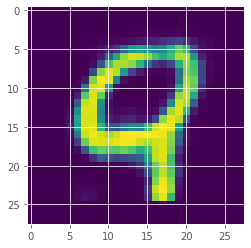

loss: 87.427910  [51200/60000]
KL_loss: 2.666615, recons_loss: 84.761307


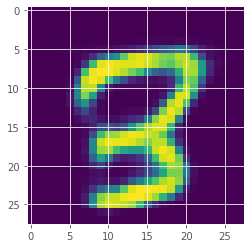

====> Average Train loss: 86.2566
====> Average Test loss: 84.9625
Validation loss decreased (85.502719 --> 84.962498).  Saving model ...
Epoch 17
-------------------------------
loss: 84.050117  [    0/60000]
KL_loss: 2.581274, recons_loss: 81.468842


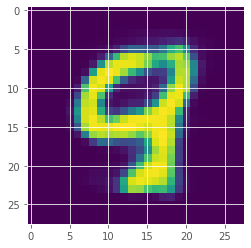

loss: 86.394333  [12800/60000]
KL_loss: 2.832759, recons_loss: 83.561577


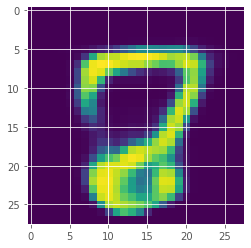

loss: 85.499046  [25600/60000]
KL_loss: 2.735847, recons_loss: 82.763214


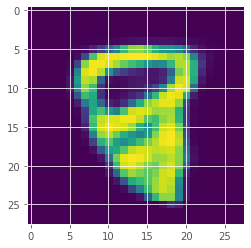

loss: 85.854294  [38400/60000]
KL_loss: 2.599082, recons_loss: 83.255226


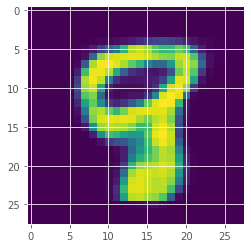

loss: 83.282692  [51200/60000]
KL_loss: 2.528593, recons_loss: 80.754112


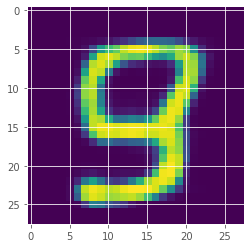

====> Average Train loss: 85.7306
====> Average Test loss: 84.5067
Validation loss decreased (84.962498 --> 84.506730).  Saving model ...
Epoch 18
-------------------------------
loss: 86.644173  [    0/60000]
KL_loss: 2.750632, recons_loss: 83.893539


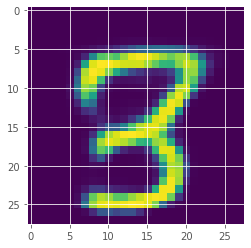

loss: 90.700241  [12800/60000]
KL_loss: 2.838466, recons_loss: 87.861786


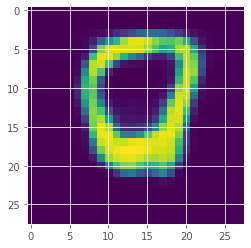

loss: 80.730972  [25600/60000]
KL_loss: 2.694390, recons_loss: 78.036583


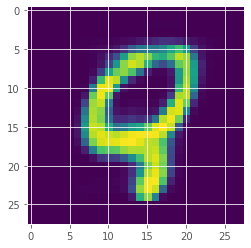

loss: 84.046013  [38400/60000]
KL_loss: 3.093650, recons_loss: 80.952377


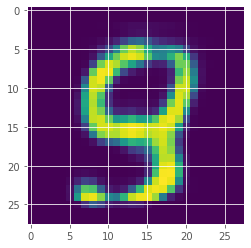

loss: 89.302887  [51200/60000]
KL_loss: 3.082764, recons_loss: 86.220123


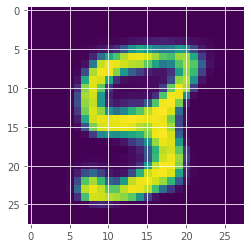

====> Average Train loss: 85.1290
====> Average Test loss: 83.8442
Validation loss decreased (84.506730 --> 83.844195).  Saving model ...
Epoch 19
-------------------------------
loss: 80.961372  [    0/60000]
KL_loss: 2.769265, recons_loss: 78.192101


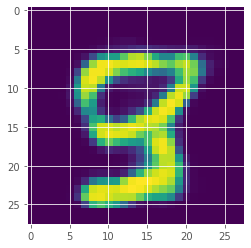

loss: 82.430473  [12800/60000]
KL_loss: 2.973154, recons_loss: 79.457314


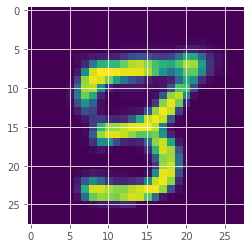

loss: 81.740608  [25600/60000]
KL_loss: 3.149105, recons_loss: 78.591515


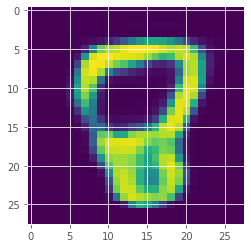

loss: 86.844879  [38400/60000]
KL_loss: 3.075593, recons_loss: 83.769272


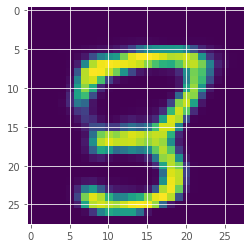

loss: 83.494774  [51200/60000]
KL_loss: 3.144789, recons_loss: 80.349998


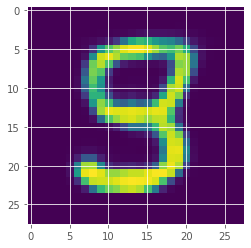

====> Average Train loss: 84.5020
====> Average Test loss: 83.3411
Validation loss decreased (83.844195 --> 83.341074).  Saving model ...
Epoch 20
-------------------------------
loss: 83.207565  [    0/60000]
KL_loss: 3.068529, recons_loss: 80.139038


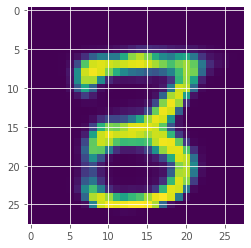

loss: 82.803696  [12800/60000]
KL_loss: 3.224642, recons_loss: 79.579056


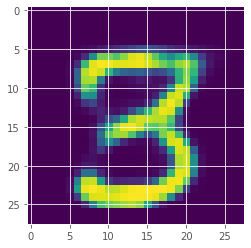

loss: 86.682091  [25600/60000]
KL_loss: 3.310503, recons_loss: 83.371582


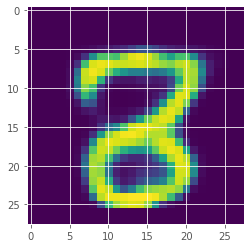

loss: 85.280678  [38400/60000]
KL_loss: 3.286732, recons_loss: 81.993958


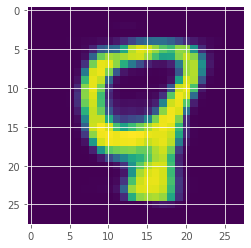

loss: 84.688271  [51200/60000]
KL_loss: 3.110837, recons_loss: 81.577446


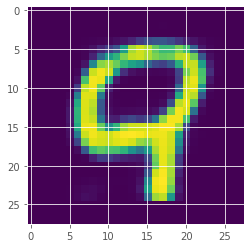

====> Average Train loss: 83.9714
====> Average Test loss: 82.8812
Validation loss decreased (83.341074 --> 82.881170).  Saving model ...
Epoch 21
-------------------------------
loss: 86.704933  [    0/60000]
KL_loss: 3.418848, recons_loss: 83.286087


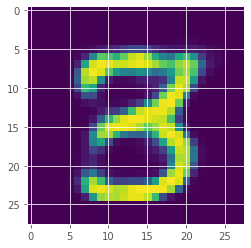

loss: 85.125549  [12800/60000]
KL_loss: 3.368400, recons_loss: 81.757141


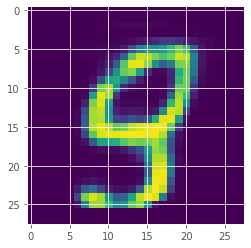

loss: 84.975578  [25600/60000]
KL_loss: 3.360594, recons_loss: 81.614983


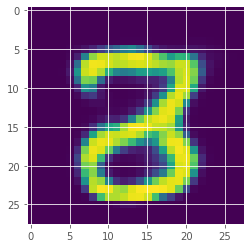

loss: 84.036919  [38400/60000]
KL_loss: 3.081906, recons_loss: 80.955002


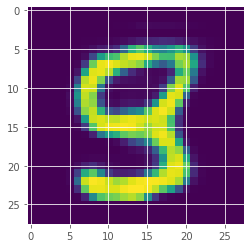

loss: 80.494133  [51200/60000]
KL_loss: 3.262019, recons_loss: 77.232124


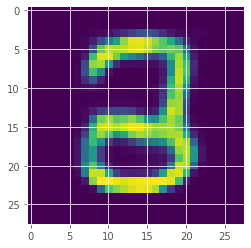

====> Average Train loss: 83.5406
====> Average Test loss: 82.4792
Validation loss decreased (82.881170 --> 82.479233).  Saving model ...
Epoch 22
-------------------------------
loss: 87.261238  [    0/60000]
KL_loss: 3.586540, recons_loss: 83.674713


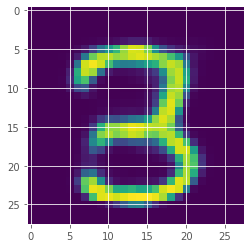

loss: 80.747719  [12800/60000]
KL_loss: 3.221745, recons_loss: 77.525970


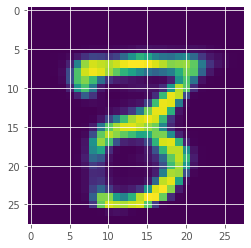

loss: 87.049713  [25600/60000]
KL_loss: 3.640980, recons_loss: 83.408730


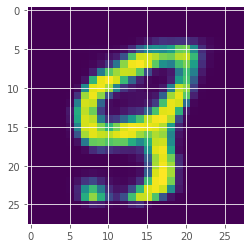

loss: 84.830154  [38400/60000]
KL_loss: 3.496883, recons_loss: 81.333260


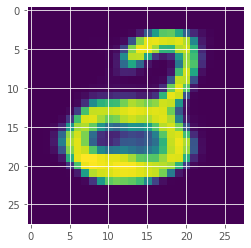

loss: 85.069618  [51200/60000]
KL_loss: 3.596417, recons_loss: 81.473175


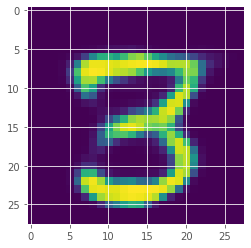

====> Average Train loss: 83.0897
====> Average Test loss: 81.9814
Validation loss decreased (82.479233 --> 81.981431).  Saving model ...
Epoch 23
-------------------------------
loss: 82.516029  [    0/60000]
KL_loss: 3.424649, recons_loss: 79.091377


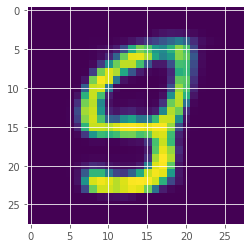

loss: 84.345886  [12800/60000]
KL_loss: 3.364853, recons_loss: 80.981018


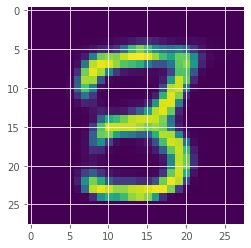

loss: 80.261353  [25600/60000]
KL_loss: 3.521553, recons_loss: 76.739784


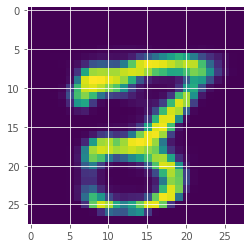

loss: 84.254951  [38400/60000]
KL_loss: 3.607939, recons_loss: 80.647003


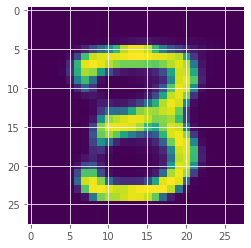

loss: 80.538116  [51200/60000]
KL_loss: 3.338593, recons_loss: 77.199516


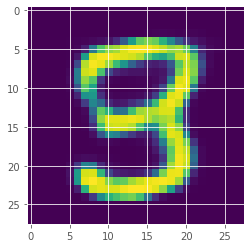

====> Average Train loss: 82.6891
====> Average Test loss: 81.6614
Validation loss decreased (81.981431 --> 81.661428).  Saving model ...
Epoch 24
-------------------------------
loss: 84.391388  [    0/60000]
KL_loss: 3.421756, recons_loss: 80.969627


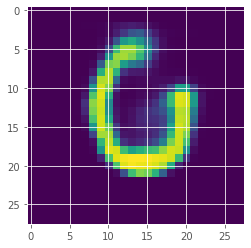

loss: 84.125488  [12800/60000]
KL_loss: 3.456183, recons_loss: 80.669304


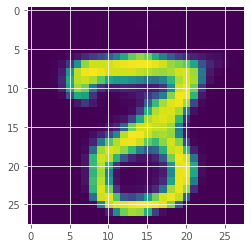

loss: 82.660858  [25600/60000]
KL_loss: 3.396167, recons_loss: 79.264687


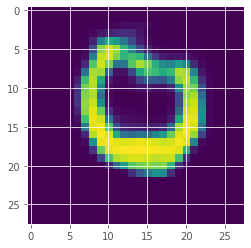

loss: 82.757683  [38400/60000]
KL_loss: 3.557478, recons_loss: 79.200211


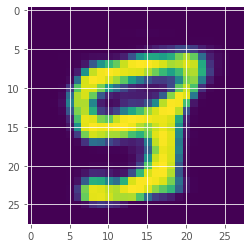

loss: 82.193329  [51200/60000]
KL_loss: 3.364876, recons_loss: 78.828461


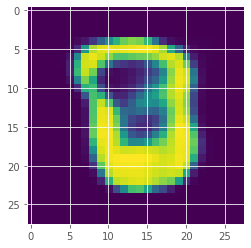

====> Average Train loss: 82.3476
====> Average Test loss: 81.3705
Validation loss decreased (81.661428 --> 81.370499).  Saving model ...
Epoch 25
-------------------------------
loss: 82.258797  [    0/60000]
KL_loss: 3.444983, recons_loss: 78.813820


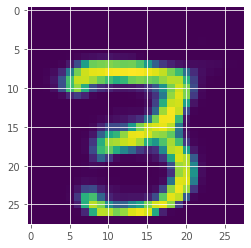

loss: 84.192329  [12800/60000]
KL_loss: 3.579347, recons_loss: 80.612984


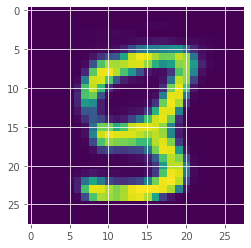

loss: 80.782066  [25600/60000]
KL_loss: 3.566378, recons_loss: 77.215691


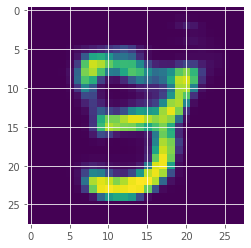

loss: 83.125641  [38400/60000]
KL_loss: 3.686368, recons_loss: 79.439255


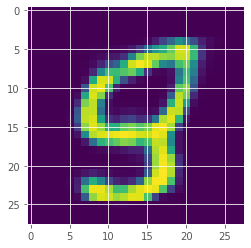

loss: 81.265594  [51200/60000]
KL_loss: 3.454907, recons_loss: 77.810692


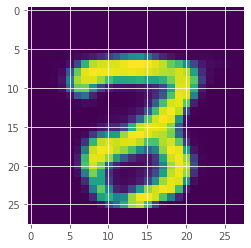

====> Average Train loss: 82.0428
====> Average Test loss: 81.4081
EarlyStopping counter: 1 out of 5
Epoch 26
-------------------------------
loss: 82.596176  [    0/60000]
KL_loss: 3.684191, recons_loss: 78.911980


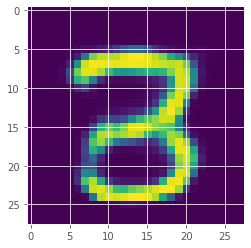

loss: 83.211060  [12800/60000]
KL_loss: 3.565048, recons_loss: 79.646034


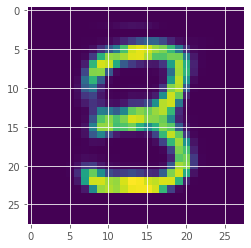

loss: 83.986595  [25600/60000]
KL_loss: 3.854924, recons_loss: 80.131676


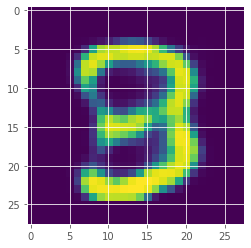

loss: 80.615891  [38400/60000]
KL_loss: 3.560946, recons_loss: 77.054924


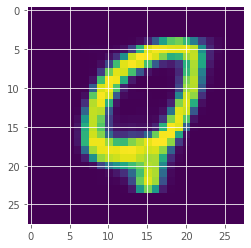

loss: 80.724403  [51200/60000]
KL_loss: 3.535064, recons_loss: 77.189323


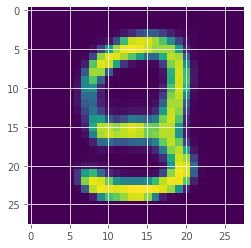

====> Average Train loss: 81.7864
====> Average Test loss: 80.8314
Validation loss decreased (81.370499 --> 80.831408).  Saving model ...
Epoch 27
-------------------------------
loss: 80.469627  [    0/60000]
KL_loss: 3.533138, recons_loss: 76.936508


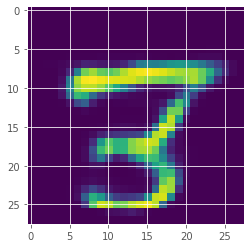

loss: 81.087646  [12800/60000]
KL_loss: 3.429482, recons_loss: 77.658180


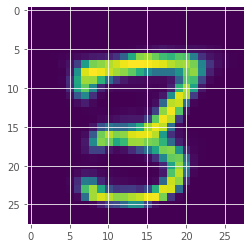

loss: 80.117317  [25600/60000]
KL_loss: 3.663279, recons_loss: 76.454048


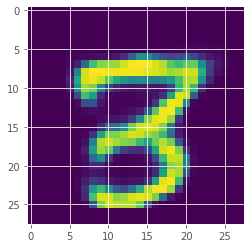

loss: 80.454086  [38400/60000]
KL_loss: 3.625764, recons_loss: 76.828323


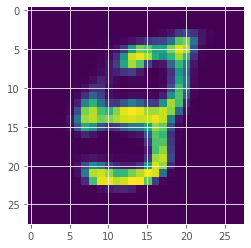

loss: 81.577171  [51200/60000]
KL_loss: 3.693678, recons_loss: 77.883507


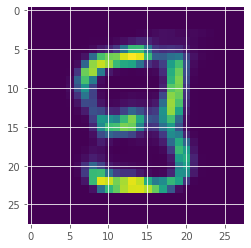

====> Average Train loss: 81.4833
====> Average Test loss: 80.5888
Validation loss decreased (80.831408 --> 80.588810).  Saving model ...
Epoch 28
-------------------------------
loss: 79.345398  [    0/60000]
KL_loss: 3.528068, recons_loss: 75.817345


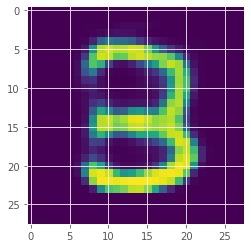

loss: 80.613342  [12800/60000]
KL_loss: 3.356222, recons_loss: 77.257118


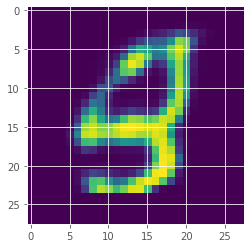

loss: 78.378578  [25600/60000]
KL_loss: 3.447258, recons_loss: 74.931320


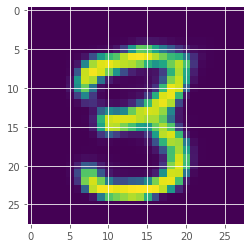

loss: 79.192200  [38400/60000]
KL_loss: 3.555358, recons_loss: 75.636848


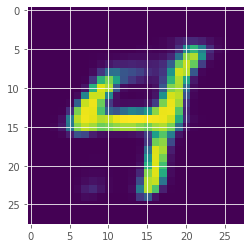

loss: 79.103821  [51200/60000]
KL_loss: 3.558683, recons_loss: 75.545143


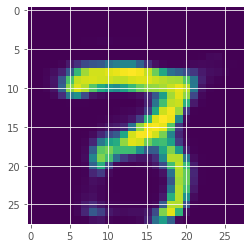

====> Average Train loss: 81.2732
====> Average Test loss: 80.3120
Validation loss decreased (80.588810 --> 80.312039).  Saving model ...
Epoch 29
-------------------------------
loss: 81.865059  [    0/60000]
KL_loss: 3.597290, recons_loss: 78.267769


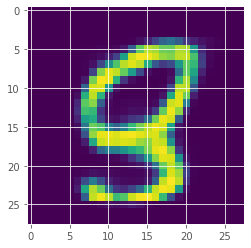

loss: 82.192459  [12800/60000]
KL_loss: 3.779237, recons_loss: 78.413216


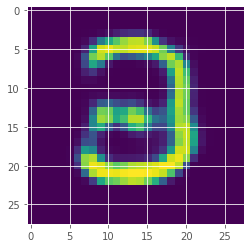

loss: 79.502357  [25600/60000]
KL_loss: 3.454817, recons_loss: 76.047531


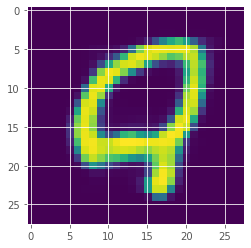

loss: 82.619225  [38400/60000]
KL_loss: 3.708877, recons_loss: 78.910355


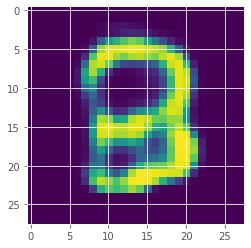

loss: 82.890221  [51200/60000]
KL_loss: 3.675678, recons_loss: 79.214531


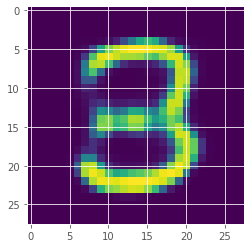

====> Average Train loss: 81.0257
====> Average Test loss: 80.1822
Validation loss decreased (80.312039 --> 80.182215).  Saving model ...
Epoch 30
-------------------------------
loss: 82.333717  [    0/60000]
KL_loss: 3.584607, recons_loss: 78.749107


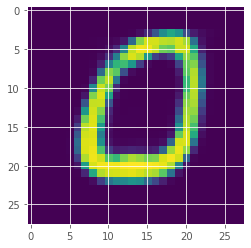

loss: 81.356377  [12800/60000]
KL_loss: 3.650810, recons_loss: 77.705582


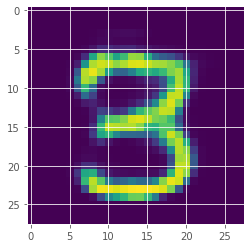

loss: 81.898941  [25600/60000]
KL_loss: 3.730042, recons_loss: 78.168884


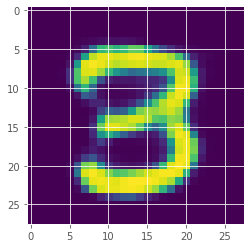

loss: 81.089394  [38400/60000]
KL_loss: 3.852601, recons_loss: 77.236794


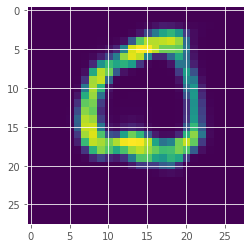

loss: 78.442513  [51200/60000]
KL_loss: 3.465400, recons_loss: 74.977104


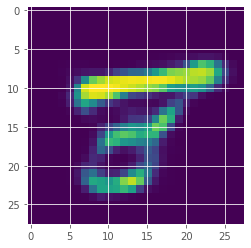

====> Average Train loss: 80.8177
====> Average Test loss: 79.8998
Validation loss decreased (80.182215 --> 79.899840).  Saving model ...
Epoch 31
-------------------------------
loss: 81.301086  [    0/60000]
KL_loss: 3.703482, recons_loss: 77.597603


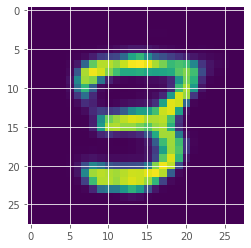

loss: 79.760773  [12800/60000]
KL_loss: 3.666244, recons_loss: 76.094536


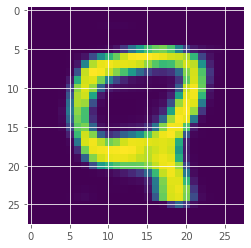

loss: 80.788185  [25600/60000]
KL_loss: 3.599643, recons_loss: 77.188560


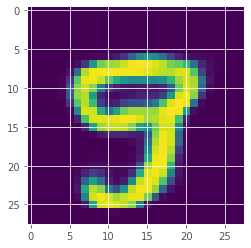

loss: 80.333862  [38400/60000]
KL_loss: 3.704434, recons_loss: 76.629425


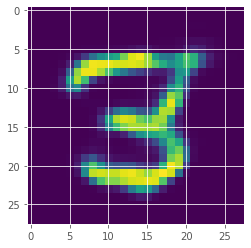

loss: 81.438812  [51200/60000]
KL_loss: 3.763896, recons_loss: 77.674904


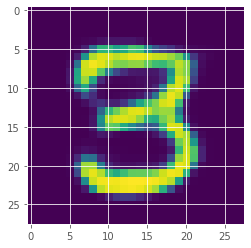

====> Average Train loss: 80.6267
====> Average Test loss: 79.7532
Validation loss decreased (79.899840 --> 79.753206).  Saving model ...
Epoch 32
-------------------------------
loss: 79.903419  [    0/60000]
KL_loss: 3.589983, recons_loss: 76.313461


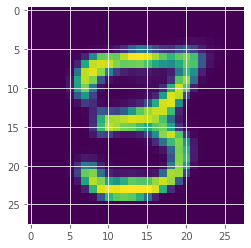

loss: 83.289742  [12800/60000]
KL_loss: 4.016566, recons_loss: 79.273163


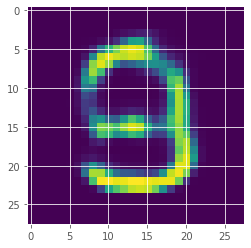

loss: 78.863937  [25600/60000]
KL_loss: 3.513133, recons_loss: 75.350822


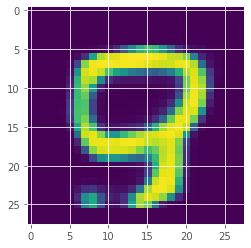

loss: 78.774979  [38400/60000]
KL_loss: 3.651463, recons_loss: 75.123512


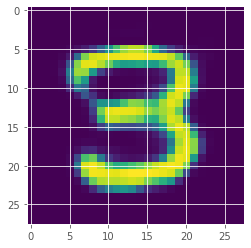

loss: 77.562737  [51200/60000]
KL_loss: 3.458155, recons_loss: 74.104584


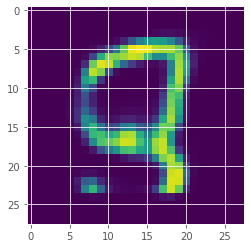

====> Average Train loss: 80.4383
====> Average Test loss: 79.6334
Validation loss decreased (79.753206 --> 79.633428).  Saving model ...
Epoch 33
-------------------------------
loss: 80.210640  [    0/60000]
KL_loss: 3.505346, recons_loss: 76.705299


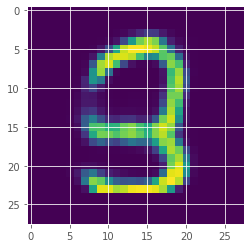

loss: 78.931160  [12800/60000]
KL_loss: 3.753396, recons_loss: 75.177780


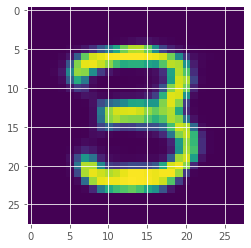

loss: 76.727982  [25600/60000]
KL_loss: 3.624812, recons_loss: 73.103172


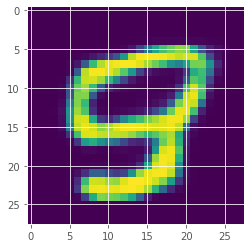

loss: 80.653419  [38400/60000]
KL_loss: 3.647854, recons_loss: 77.005569


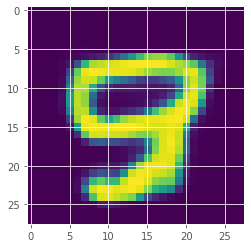

loss: 82.231453  [51200/60000]
KL_loss: 3.833801, recons_loss: 78.397644


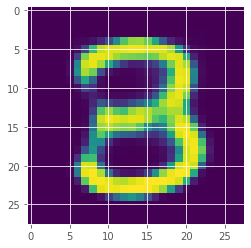

====> Average Train loss: 80.2808
====> Average Test loss: 79.3834
Validation loss decreased (79.633428 --> 79.383360).  Saving model ...
Epoch 34
-------------------------------
loss: 79.750389  [    0/60000]
KL_loss: 3.810035, recons_loss: 75.940369


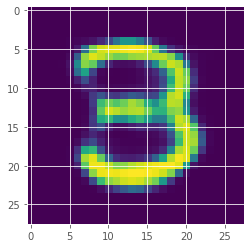

loss: 82.164566  [12800/60000]
KL_loss: 3.809178, recons_loss: 78.355385


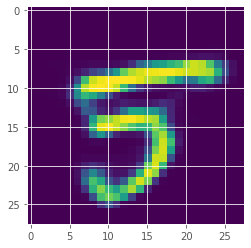

loss: 82.068985  [25600/60000]
KL_loss: 3.820739, recons_loss: 78.248238


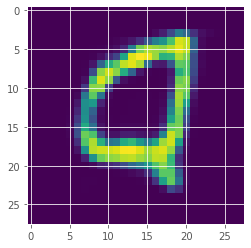

loss: 79.573517  [38400/60000]
KL_loss: 3.591823, recons_loss: 75.981705


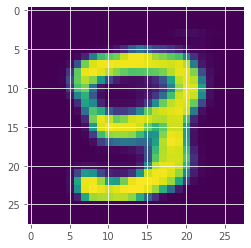

loss: 78.053543  [51200/60000]
KL_loss: 3.658736, recons_loss: 74.394806


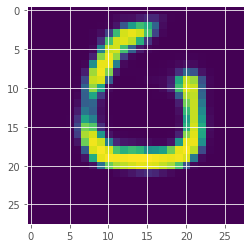

====> Average Train loss: 80.0960
====> Average Test loss: 79.2661
Validation loss decreased (79.383360 --> 79.266145).  Saving model ...
Epoch 35
-------------------------------
loss: 79.020569  [    0/60000]
KL_loss: 3.644102, recons_loss: 75.376457


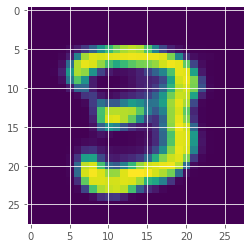

loss: 77.718224  [12800/60000]
KL_loss: 3.594211, recons_loss: 74.124001


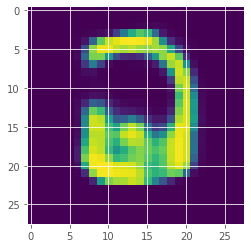

loss: 82.077675  [25600/60000]
KL_loss: 3.979989, recons_loss: 78.097687


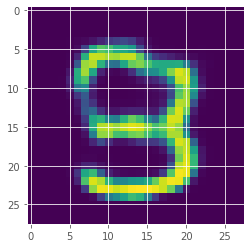

loss: 79.887962  [38400/60000]
KL_loss: 3.575999, recons_loss: 76.311958


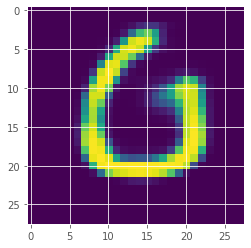

loss: 81.920372  [51200/60000]
KL_loss: 3.581954, recons_loss: 78.338409


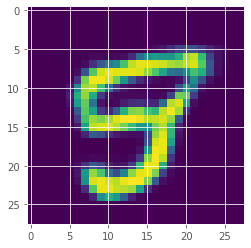

====> Average Train loss: 79.9249
====> Average Test loss: 79.0672
Validation loss decreased (79.266145 --> 79.067164).  Saving model ...
Epoch 36
-------------------------------
loss: 79.864555  [    0/60000]
KL_loss: 3.685576, recons_loss: 76.178963


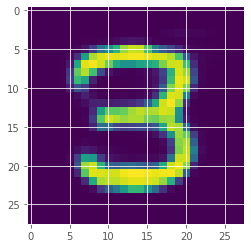

loss: 75.476639  [12800/60000]
KL_loss: 3.386865, recons_loss: 72.089760


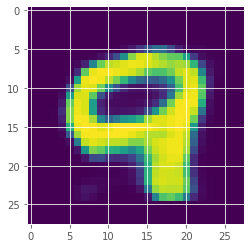

loss: 82.014412  [25600/60000]
KL_loss: 3.809412, recons_loss: 78.204994


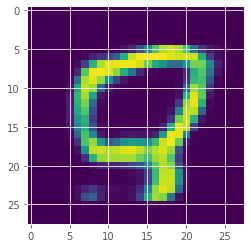

loss: 82.864967  [38400/60000]
KL_loss: 3.767132, recons_loss: 79.097839


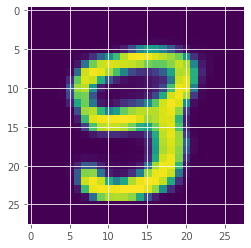

loss: 84.610977  [51200/60000]
KL_loss: 3.788251, recons_loss: 80.822708


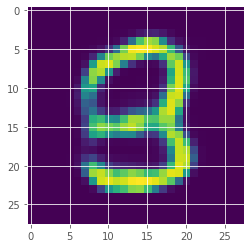

====> Average Train loss: 79.7672
====> Average Test loss: 79.0230
Validation loss decreased (79.067164 --> 79.023047).  Saving model ...
Epoch 37
-------------------------------
loss: 81.429451  [    0/60000]
KL_loss: 3.637951, recons_loss: 77.791496


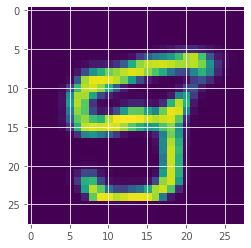

loss: 84.089294  [12800/60000]
KL_loss: 3.878504, recons_loss: 80.210793


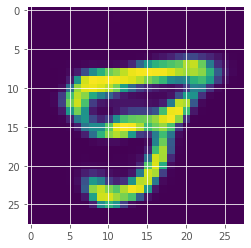

loss: 77.057610  [25600/60000]
KL_loss: 3.613806, recons_loss: 73.443810


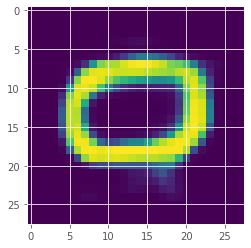

loss: 83.299355  [38400/60000]
KL_loss: 3.748859, recons_loss: 79.550491


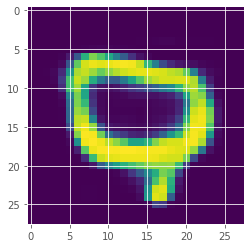

loss: 79.373726  [51200/60000]
KL_loss: 3.544799, recons_loss: 75.828918


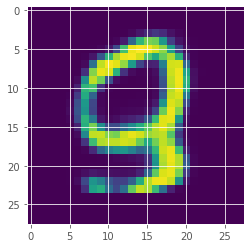

====> Average Train loss: 79.6416
====> Average Test loss: 78.8790
Validation loss decreased (79.023047 --> 78.879029).  Saving model ...
Epoch 38
-------------------------------
loss: 78.356934  [    0/60000]
KL_loss: 3.650336, recons_loss: 74.706604


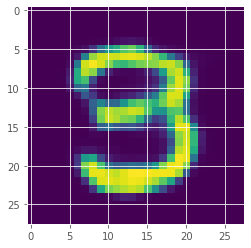

loss: 81.790108  [12800/60000]
KL_loss: 3.889922, recons_loss: 77.900192


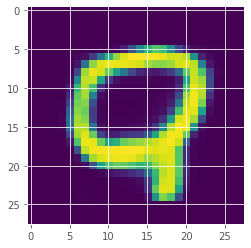

loss: 79.404785  [25600/60000]
KL_loss: 3.660703, recons_loss: 75.744064


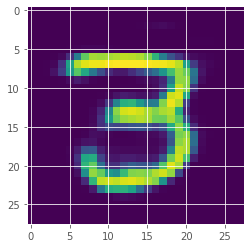

loss: 80.417549  [38400/60000]
KL_loss: 3.529000, recons_loss: 76.888542


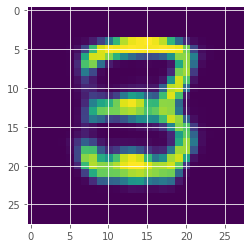

loss: 82.620247  [51200/60000]
KL_loss: 3.736645, recons_loss: 78.883598


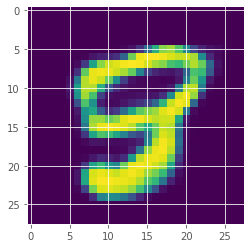

====> Average Train loss: 79.4700
====> Average Test loss: 78.6503
Validation loss decreased (78.879029 --> 78.650264).  Saving model ...
Epoch 39
-------------------------------
loss: 76.865128  [    0/60000]
KL_loss: 3.541352, recons_loss: 73.323761


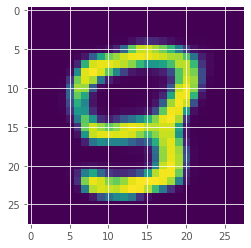

loss: 75.588219  [12800/60000]
KL_loss: 3.610480, recons_loss: 71.977753


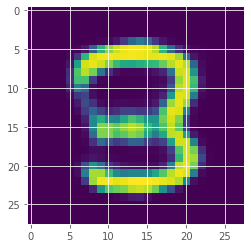

loss: 78.064964  [25600/60000]
KL_loss: 3.769971, recons_loss: 74.294998


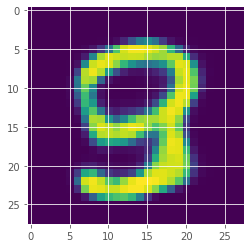

loss: 80.668335  [38400/60000]
KL_loss: 3.855144, recons_loss: 76.813202


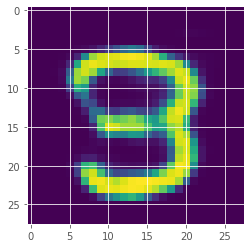

loss: 80.944931  [51200/60000]
KL_loss: 3.750950, recons_loss: 77.193962


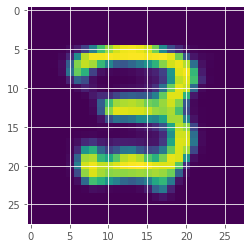

====> Average Train loss: 79.3531
====> Average Test loss: 78.5556
Validation loss decreased (78.650264 --> 78.555614).  Saving model ...
Epoch 40
-------------------------------
loss: 79.694931  [    0/60000]
KL_loss: 3.774246, recons_loss: 75.920677


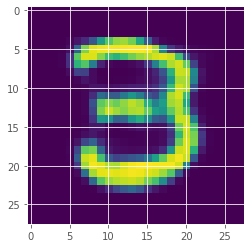

loss: 79.684418  [12800/60000]
KL_loss: 3.629589, recons_loss: 76.054817


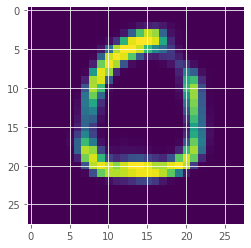

loss: 76.394058  [25600/60000]
KL_loss: 3.686194, recons_loss: 72.707840


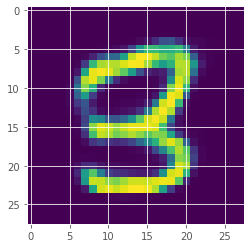

loss: 81.589508  [38400/60000]
KL_loss: 3.511871, recons_loss: 78.077644


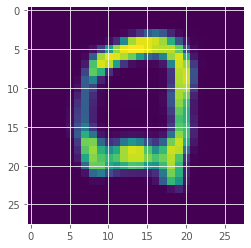

loss: 79.368546  [51200/60000]
KL_loss: 3.528920, recons_loss: 75.839622


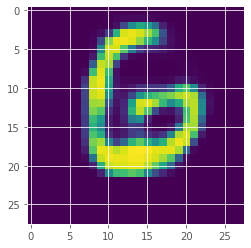

====> Average Train loss: 79.2319
====> Average Test loss: 78.5559
EarlyStopping counter: 1 out of 5
Epoch 41
-------------------------------
loss: 78.620049  [    0/60000]
KL_loss: 3.733225, recons_loss: 74.886803


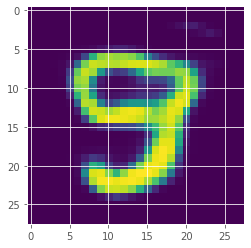

loss: 83.702583  [12800/60000]
KL_loss: 3.838360, recons_loss: 79.864220


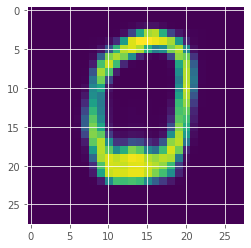

loss: 81.665413  [25600/60000]
KL_loss: 3.798095, recons_loss: 77.867332


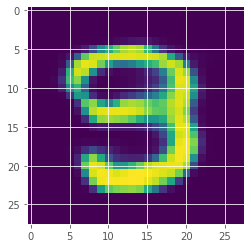

loss: 76.446625  [38400/60000]
KL_loss: 3.584000, recons_loss: 72.862617


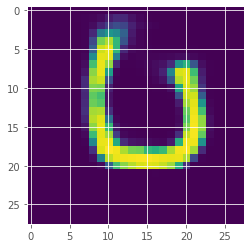

loss: 78.879784  [51200/60000]
KL_loss: 3.697474, recons_loss: 75.182304


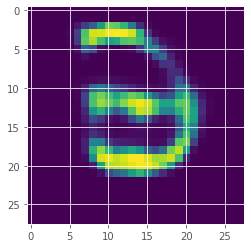

====> Average Train loss: 79.0975
====> Average Test loss: 78.2816
Validation loss decreased (78.555614 --> 78.281553).  Saving model ...
Epoch 42
-------------------------------
loss: 77.612076  [    0/60000]
KL_loss: 3.545052, recons_loss: 74.067017


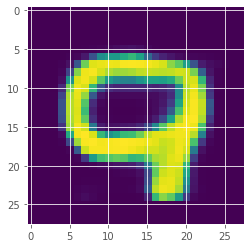

loss: 79.809990  [12800/60000]
KL_loss: 3.772481, recons_loss: 76.037498


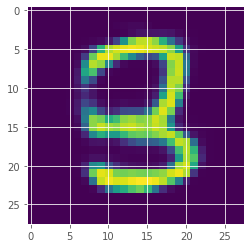

loss: 75.721283  [25600/60000]
KL_loss: 3.608327, recons_loss: 72.112953


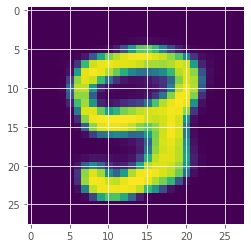

loss: 78.765846  [38400/60000]
KL_loss: 3.587774, recons_loss: 75.178078


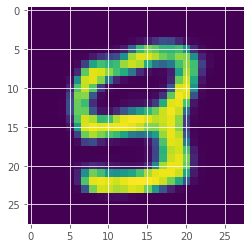

loss: 78.681526  [51200/60000]
KL_loss: 3.631233, recons_loss: 75.050293


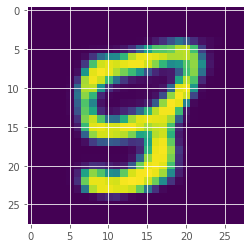

====> Average Train loss: 78.9773
====> Average Test loss: 78.2812
Validation loss decreased (78.281553 --> 78.281228).  Saving model ...
Epoch 43
-------------------------------
loss: 77.862633  [    0/60000]
KL_loss: 3.700887, recons_loss: 74.161766


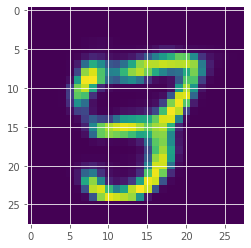

loss: 77.701241  [12800/60000]
KL_loss: 3.804424, recons_loss: 73.896812


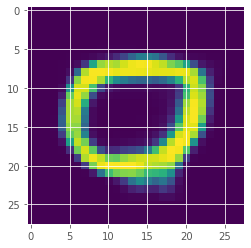

loss: 82.820084  [25600/60000]
KL_loss: 3.936096, recons_loss: 78.883987


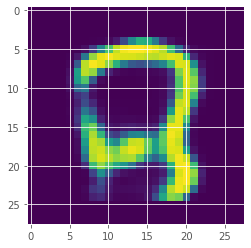

loss: 77.995659  [38400/60000]
KL_loss: 3.739176, recons_loss: 74.256508


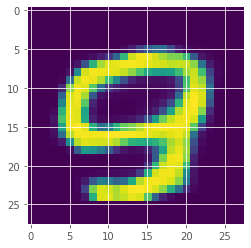

loss: 83.910072  [51200/60000]
KL_loss: 3.836376, recons_loss: 80.073708


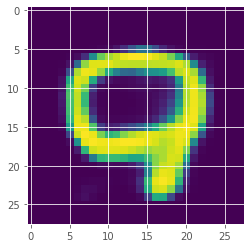

====> Average Train loss: 78.8793
====> Average Test loss: 78.1461
Validation loss decreased (78.281228 --> 78.146087).  Saving model ...
Epoch 44
-------------------------------
loss: 79.833565  [    0/60000]
KL_loss: 3.829297, recons_loss: 76.004280


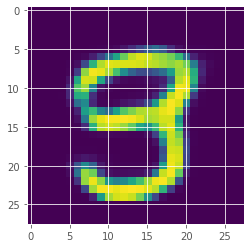

loss: 80.292366  [12800/60000]
KL_loss: 3.460511, recons_loss: 76.831856


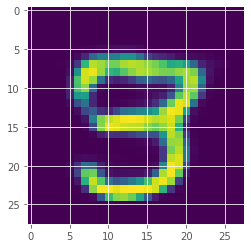

loss: 75.431488  [25600/60000]
KL_loss: 3.490319, recons_loss: 71.941177


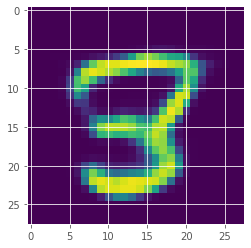

loss: 78.356316  [38400/60000]
KL_loss: 3.700179, recons_loss: 74.656151


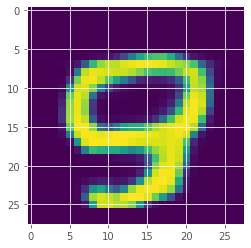

loss: 76.102997  [51200/60000]
KL_loss: 3.796499, recons_loss: 72.306496


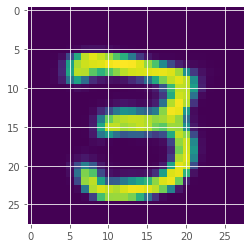

====> Average Train loss: 78.7456
====> Average Test loss: 78.0451
Validation loss decreased (78.146087 --> 78.045092).  Saving model ...
Epoch 45
-------------------------------
loss: 78.606720  [    0/60000]
KL_loss: 3.641717, recons_loss: 74.965004


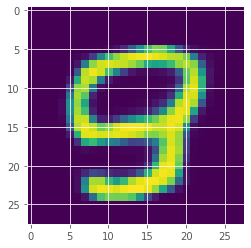

loss: 76.804077  [12800/60000]
KL_loss: 3.811739, recons_loss: 72.992332


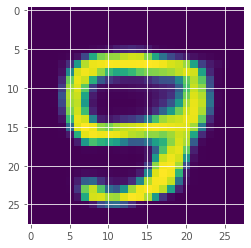

loss: 80.854614  [25600/60000]
KL_loss: 3.674881, recons_loss: 77.179741


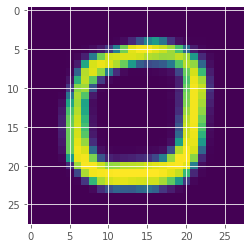

loss: 79.817322  [38400/60000]
KL_loss: 3.588977, recons_loss: 76.228348


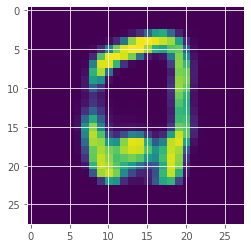

loss: 79.120003  [51200/60000]
KL_loss: 3.852118, recons_loss: 75.267883


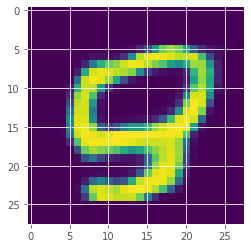

====> Average Train loss: 78.6343
====> Average Test loss: 77.8783
Validation loss decreased (78.045092 --> 77.878274).  Saving model ...
Epoch 46
-------------------------------
loss: 77.071518  [    0/60000]
KL_loss: 3.524881, recons_loss: 73.546654


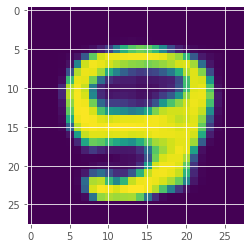

loss: 77.537743  [12800/60000]
KL_loss: 3.754400, recons_loss: 73.783318


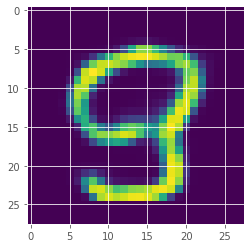

loss: 78.244682  [25600/60000]
KL_loss: 3.757537, recons_loss: 74.487144


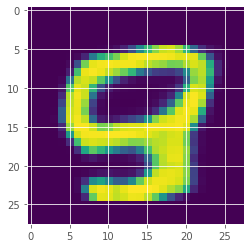

loss: 79.879555  [38400/60000]
KL_loss: 3.700421, recons_loss: 76.179138


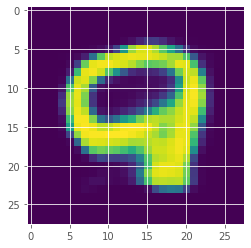

loss: 78.964195  [51200/60000]
KL_loss: 3.602603, recons_loss: 75.361603


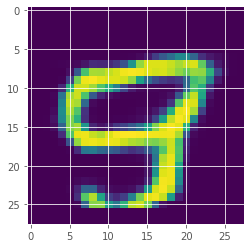

====> Average Train loss: 78.5204
====> Average Test loss: 77.8326
Validation loss decreased (77.878274 --> 77.832590).  Saving model ...
Epoch 47
-------------------------------
loss: 77.645409  [    0/60000]
KL_loss: 3.773721, recons_loss: 73.871704


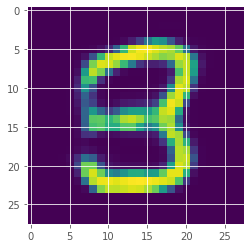

loss: 78.114883  [12800/60000]
KL_loss: 3.677392, recons_loss: 74.437477


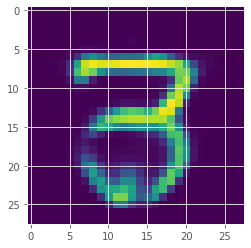

loss: 78.587898  [25600/60000]
KL_loss: 3.607867, recons_loss: 74.980026


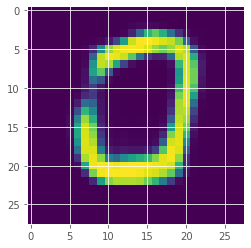

loss: 76.982956  [38400/60000]
KL_loss: 3.627627, recons_loss: 73.355324


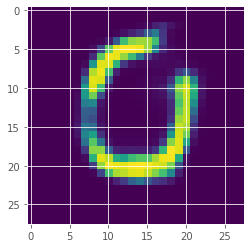

loss: 75.309792  [51200/60000]
KL_loss: 3.799111, recons_loss: 71.510674


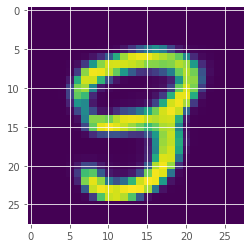

====> Average Train loss: 78.4665
====> Average Test loss: 77.7414
Validation loss decreased (77.832590 --> 77.741365).  Saving model ...
Epoch 48
-------------------------------
loss: 79.942177  [    0/60000]
KL_loss: 3.494318, recons_loss: 76.447861


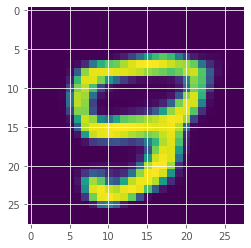

loss: 79.286369  [12800/60000]
KL_loss: 3.911034, recons_loss: 75.375343


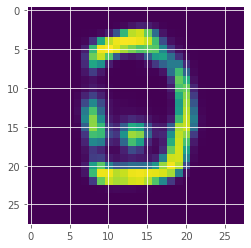

loss: 80.053963  [25600/60000]
KL_loss: 3.794562, recons_loss: 76.259415


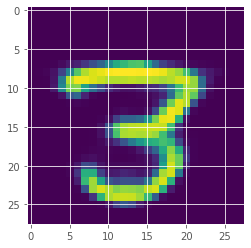

loss: 74.343704  [38400/60000]
KL_loss: 3.400846, recons_loss: 70.942863


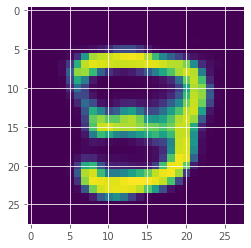

loss: 76.489510  [51200/60000]
KL_loss: 3.689840, recons_loss: 72.799675


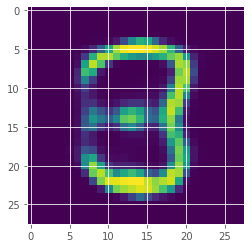

====> Average Train loss: 78.3405
====> Average Test loss: 77.7087
Validation loss decreased (77.741365 --> 77.708683).  Saving model ...
Epoch 49
-------------------------------
loss: 80.111649  [    0/60000]
KL_loss: 3.598914, recons_loss: 76.512749


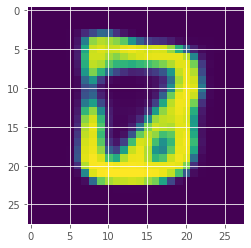

loss: 75.897430  [12800/60000]
KL_loss: 3.617455, recons_loss: 72.279984


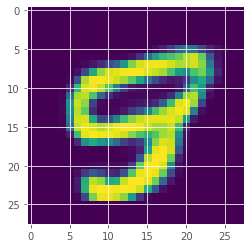

loss: 77.763062  [25600/60000]
KL_loss: 3.657927, recons_loss: 74.105156


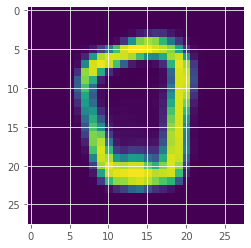

loss: 76.128098  [38400/60000]
KL_loss: 3.795768, recons_loss: 72.332321


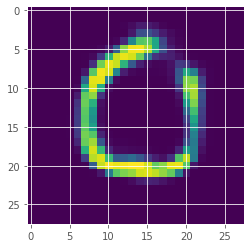

loss: 76.029305  [51200/60000]
KL_loss: 3.690874, recons_loss: 72.338425


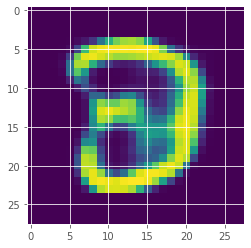

====> Average Train loss: 78.2483
====> Average Test loss: 77.6724
Validation loss decreased (77.708683 --> 77.672399).  Saving model ...
Epoch 50
-------------------------------
loss: 79.545296  [    0/60000]
KL_loss: 3.879569, recons_loss: 75.665710


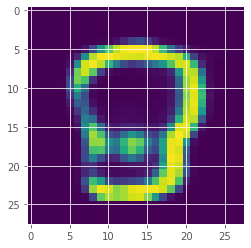

loss: 80.917694  [12800/60000]
KL_loss: 3.735906, recons_loss: 77.181786


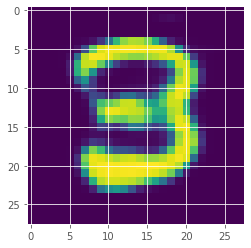

loss: 79.780434  [25600/60000]
KL_loss: 3.780547, recons_loss: 75.999878


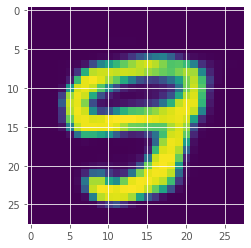

loss: 80.986252  [38400/60000]
KL_loss: 3.988031, recons_loss: 76.998215


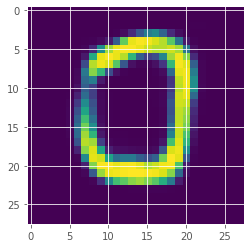

loss: 73.825676  [51200/60000]
KL_loss: 3.506100, recons_loss: 70.319572


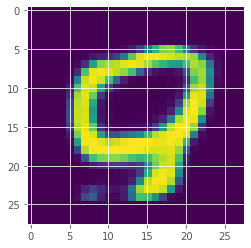

====> Average Train loss: 78.1778
====> Average Test loss: 77.5219
Validation loss decreased (77.672399 --> 77.521874).  Saving model ...
Epoch 51
-------------------------------
loss: 79.130020  [    0/60000]
KL_loss: 3.893762, recons_loss: 75.236252


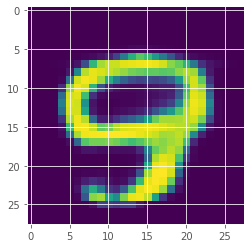

loss: 77.459518  [12800/60000]
KL_loss: 3.629534, recons_loss: 73.829979


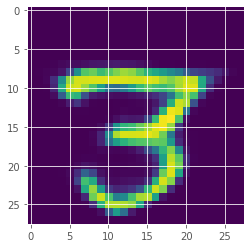

loss: 78.170265  [25600/60000]
KL_loss: 3.816216, recons_loss: 74.354042


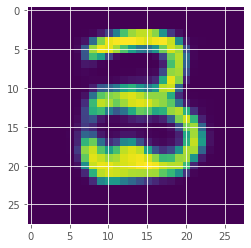

loss: 78.899292  [38400/60000]
KL_loss: 3.846359, recons_loss: 75.052940


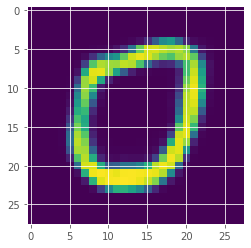

loss: 80.332909  [51200/60000]
KL_loss: 3.860603, recons_loss: 76.472305


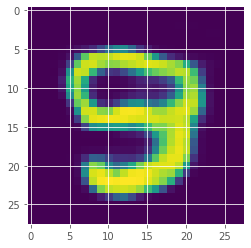

====> Average Train loss: 78.0667
====> Average Test loss: 77.3830
Validation loss decreased (77.521874 --> 77.382964).  Saving model ...
Epoch 52
-------------------------------
loss: 76.517769  [    0/60000]
KL_loss: 3.702224, recons_loss: 72.815544


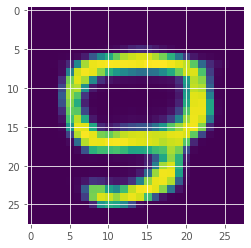

loss: 79.385971  [12800/60000]
KL_loss: 3.886423, recons_loss: 75.499550


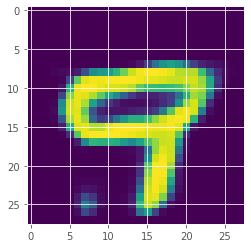

loss: 75.947166  [25600/60000]
KL_loss: 3.606363, recons_loss: 72.340805


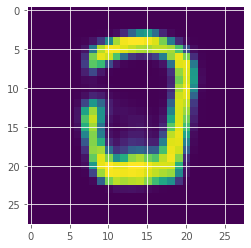

loss: 79.998268  [38400/60000]
KL_loss: 3.683565, recons_loss: 76.314705


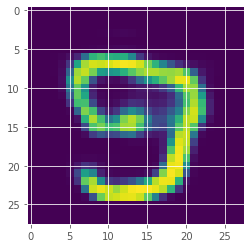

loss: 78.734825  [51200/60000]
KL_loss: 3.733022, recons_loss: 75.001816


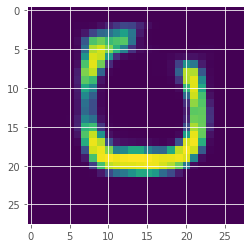

====> Average Train loss: 77.9876
====> Average Test loss: 77.3026
Validation loss decreased (77.382964 --> 77.302566).  Saving model ...
Epoch 53
-------------------------------
loss: 79.988937  [    0/60000]
KL_loss: 3.742634, recons_loss: 76.246300


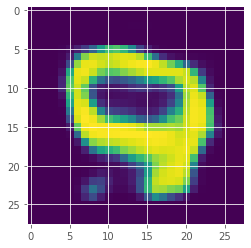

loss: 75.285431  [12800/60000]
KL_loss: 3.800300, recons_loss: 71.485115


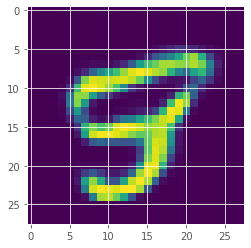

loss: 76.814789  [25600/60000]
KL_loss: 3.544004, recons_loss: 73.270782


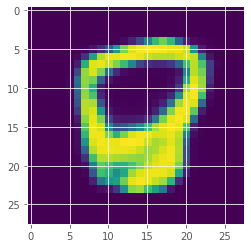

loss: 75.825424  [38400/60000]
KL_loss: 3.764406, recons_loss: 72.061020


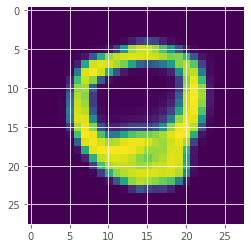

loss: 80.294861  [51200/60000]
KL_loss: 3.950874, recons_loss: 76.343994


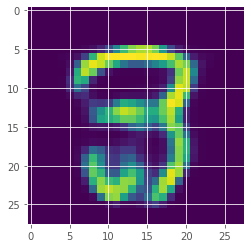

====> Average Train loss: 77.8893
====> Average Test loss: 77.2373
Validation loss decreased (77.302566 --> 77.237290).  Saving model ...
Epoch 54
-------------------------------
loss: 78.860870  [    0/60000]
KL_loss: 3.667198, recons_loss: 75.193680


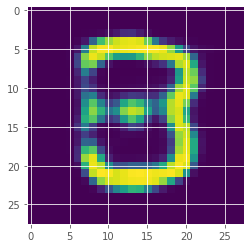

loss: 77.441895  [12800/60000]
KL_loss: 3.760930, recons_loss: 73.680977


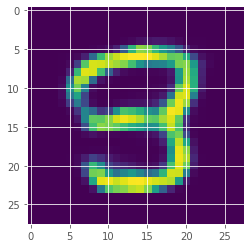

loss: 76.391693  [25600/60000]
KL_loss: 3.706080, recons_loss: 72.685623


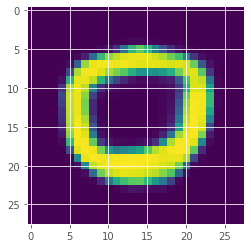

loss: 78.407669  [38400/60000]
KL_loss: 3.685329, recons_loss: 74.722321


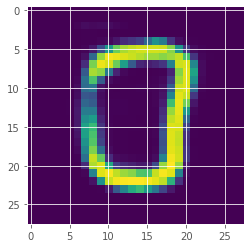

loss: 80.143425  [51200/60000]
KL_loss: 3.839558, recons_loss: 76.303856


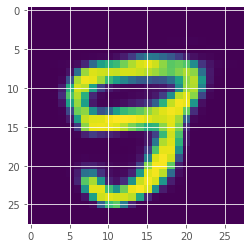

====> Average Train loss: 77.8245
====> Average Test loss: 77.2010
Validation loss decreased (77.237290 --> 77.200952).  Saving model ...
Epoch 55
-------------------------------
loss: 77.390671  [    0/60000]
KL_loss: 3.743663, recons_loss: 73.647003


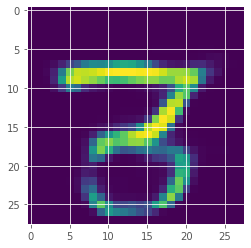

loss: 78.493851  [12800/60000]
KL_loss: 3.707134, recons_loss: 74.786720


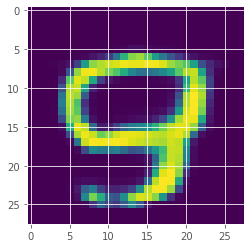

loss: 77.152954  [25600/60000]
KL_loss: 3.728981, recons_loss: 73.423988


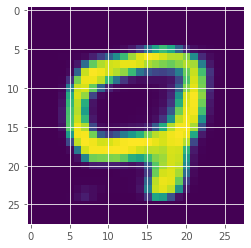

loss: 76.377350  [38400/60000]
KL_loss: 3.761880, recons_loss: 72.615479


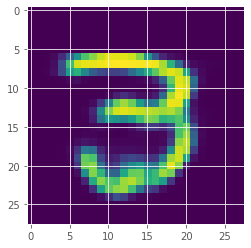

loss: 74.477318  [51200/60000]
KL_loss: 3.507524, recons_loss: 70.969803


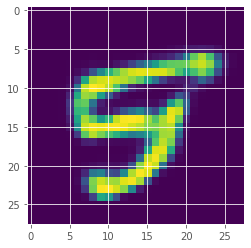

====> Average Train loss: 77.7376
====> Average Test loss: 77.1520
Validation loss decreased (77.200952 --> 77.151984).  Saving model ...
Epoch 56
-------------------------------
loss: 76.787476  [    0/60000]
KL_loss: 3.711336, recons_loss: 73.076141


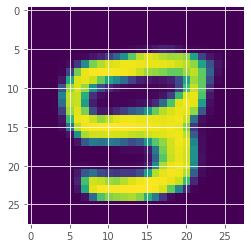

loss: 76.791542  [12800/60000]
KL_loss: 3.724280, recons_loss: 73.067268


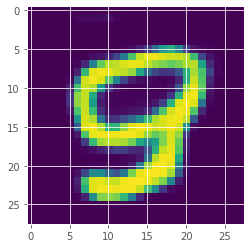

loss: 75.920464  [25600/60000]
KL_loss: 3.745069, recons_loss: 72.175392


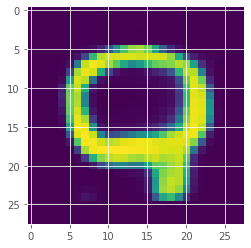

loss: 77.470055  [38400/60000]
KL_loss: 3.804747, recons_loss: 73.665314


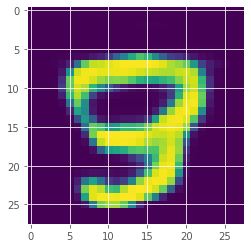

loss: 78.955246  [51200/60000]
KL_loss: 3.968639, recons_loss: 74.986618


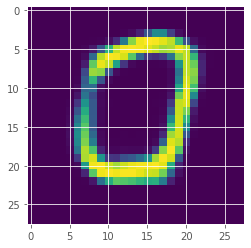

====> Average Train loss: 77.6847
====> Average Test loss: 77.0322
Validation loss decreased (77.151984 --> 77.032227).  Saving model ...
Epoch 57
-------------------------------
loss: 75.234726  [    0/60000]
KL_loss: 3.880217, recons_loss: 71.354530


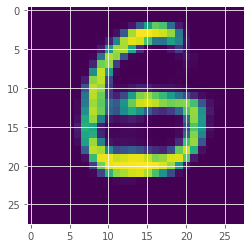

loss: 76.600647  [12800/60000]
KL_loss: 3.687537, recons_loss: 72.913101


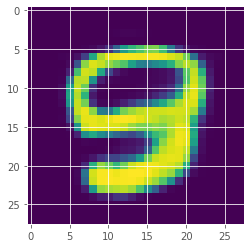

loss: 77.234573  [25600/60000]
KL_loss: 3.737908, recons_loss: 73.496651


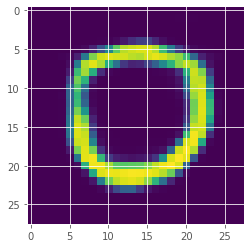

loss: 78.263580  [38400/60000]
KL_loss: 3.851906, recons_loss: 74.411674


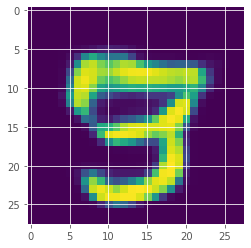

loss: 75.811638  [51200/60000]
KL_loss: 3.678639, recons_loss: 72.132988


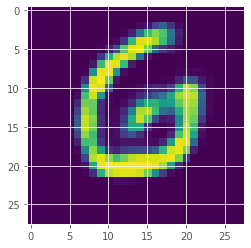

====> Average Train loss: 77.6132
====> Average Test loss: 77.0035
Validation loss decreased (77.032227 --> 77.003545).  Saving model ...
Epoch 58
-------------------------------
loss: 77.881081  [    0/60000]
KL_loss: 3.897150, recons_loss: 73.983940


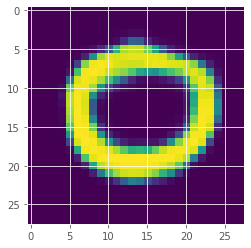

loss: 79.270325  [12800/60000]
KL_loss: 3.839638, recons_loss: 75.430656


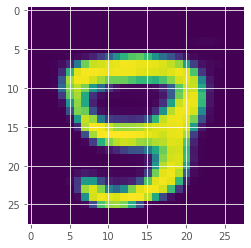

loss: 76.929970  [25600/60000]
KL_loss: 3.880472, recons_loss: 73.049492


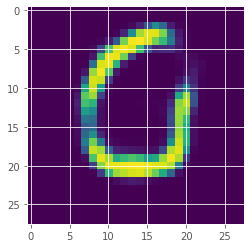

loss: 74.274887  [38400/60000]
KL_loss: 3.862168, recons_loss: 70.412727


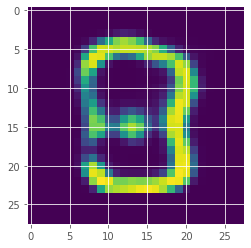

loss: 76.102074  [51200/60000]
KL_loss: 3.779862, recons_loss: 72.322212


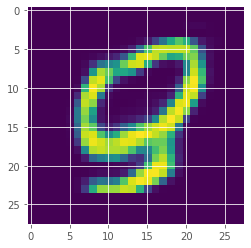

====> Average Train loss: 77.5115
====> Average Test loss: 76.8862
Validation loss decreased (77.003545 --> 76.886173).  Saving model ...
Epoch 59
-------------------------------
loss: 76.100563  [    0/60000]
KL_loss: 3.771197, recons_loss: 72.329376


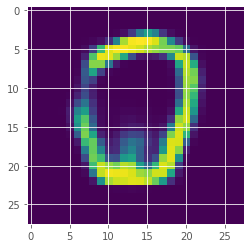

loss: 78.623276  [12800/60000]
KL_loss: 3.954350, recons_loss: 74.668938


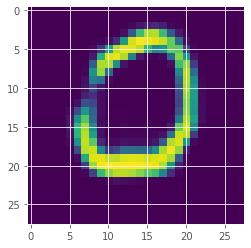

loss: 77.020622  [25600/60000]
KL_loss: 3.891747, recons_loss: 73.128876


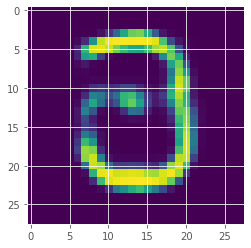

loss: 77.144432  [38400/60000]
KL_loss: 3.799833, recons_loss: 73.344589


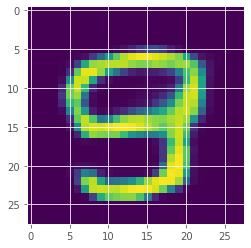

loss: 73.925095  [51200/60000]
KL_loss: 3.755745, recons_loss: 70.169350


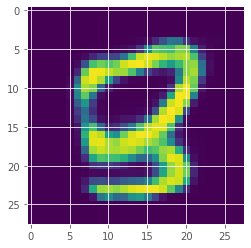

====> Average Train loss: 77.4477
====> Average Test loss: 76.8288
Validation loss decreased (76.886173 --> 76.828812).  Saving model ...
Epoch 60
-------------------------------
loss: 78.840714  [    0/60000]
KL_loss: 3.851723, recons_loss: 74.988991


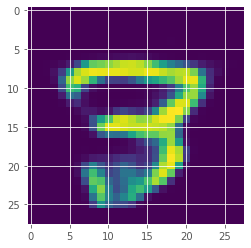

loss: 75.853096  [12800/60000]
KL_loss: 3.724766, recons_loss: 72.128319


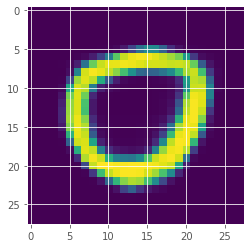

loss: 76.661072  [25600/60000]
KL_loss: 3.808739, recons_loss: 72.852333


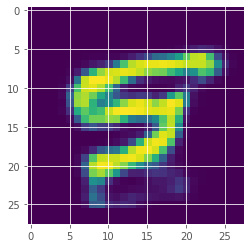

loss: 77.070381  [38400/60000]
KL_loss: 3.816344, recons_loss: 73.254044


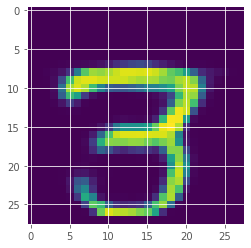

loss: 79.459007  [51200/60000]
KL_loss: 3.834763, recons_loss: 75.624237


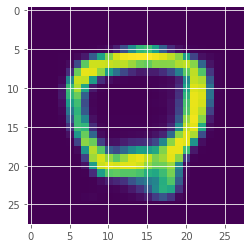

====> Average Train loss: 77.3899
====> Average Test loss: 76.7312
Validation loss decreased (76.828812 --> 76.731210).  Saving model ...
Epoch 61
-------------------------------
loss: 78.019554  [    0/60000]
KL_loss: 3.720907, recons_loss: 74.298660


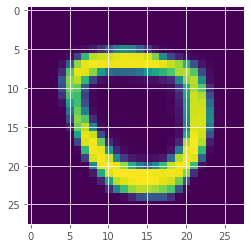

loss: 75.032562  [12800/60000]
KL_loss: 3.763890, recons_loss: 71.268646


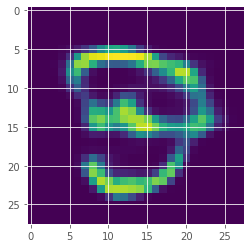

loss: 78.314156  [25600/60000]
KL_loss: 3.969462, recons_loss: 74.344711


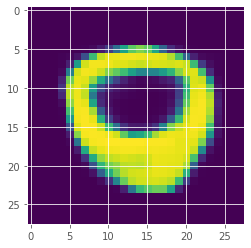

loss: 78.295776  [38400/60000]
KL_loss: 3.925566, recons_loss: 74.370209


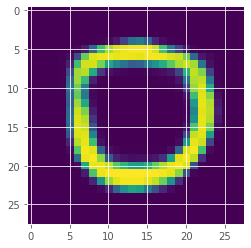

loss: 76.854958  [51200/60000]
KL_loss: 3.988535, recons_loss: 72.866409


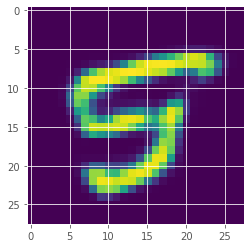

====> Average Train loss: 77.3162
====> Average Test loss: 76.6994
Validation loss decreased (76.731210 --> 76.699436).  Saving model ...
Epoch 62
-------------------------------
loss: 74.980087  [    0/60000]
KL_loss: 3.789624, recons_loss: 71.190460


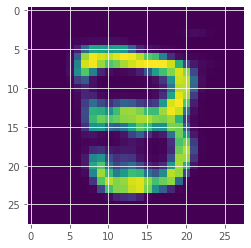

loss: 75.176277  [12800/60000]
KL_loss: 3.691983, recons_loss: 71.484299


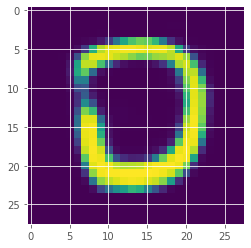

loss: 77.228188  [25600/60000]
KL_loss: 3.699825, recons_loss: 73.528366


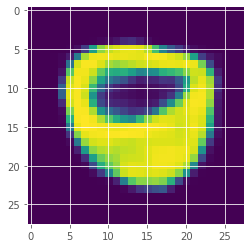

loss: 76.156479  [38400/60000]
KL_loss: 3.784606, recons_loss: 72.371864


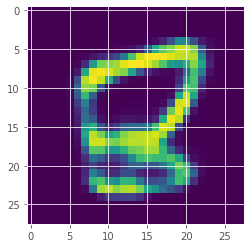

loss: 76.626076  [51200/60000]
KL_loss: 3.853314, recons_loss: 72.772758


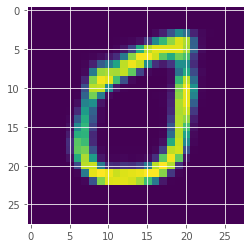

====> Average Train loss: 77.2535
====> Average Test loss: 76.6075
Validation loss decreased (76.699436 --> 76.607520).  Saving model ...
Epoch 63
-------------------------------
loss: 78.716530  [    0/60000]
KL_loss: 3.998842, recons_loss: 74.717705


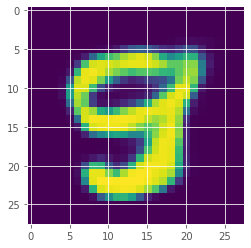

loss: 77.261589  [12800/60000]
KL_loss: 3.874773, recons_loss: 73.386810


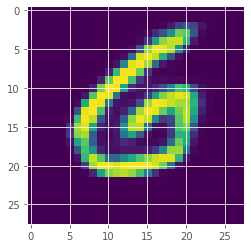

loss: 80.150856  [25600/60000]
KL_loss: 3.888187, recons_loss: 76.262657


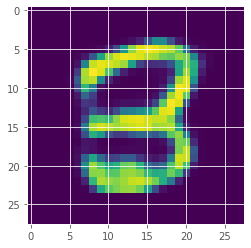

loss: 78.195152  [38400/60000]
KL_loss: 3.953388, recons_loss: 74.241753


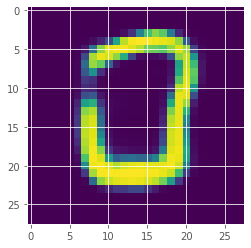

loss: 77.140312  [51200/60000]
KL_loss: 3.973125, recons_loss: 73.167191


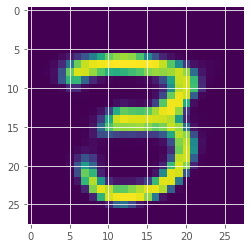

====> Average Train loss: 77.1955
====> Average Test loss: 76.6043
Validation loss decreased (76.607520 --> 76.604290).  Saving model ...
Epoch 64
-------------------------------
loss: 76.492126  [    0/60000]
KL_loss: 3.802134, recons_loss: 72.690002


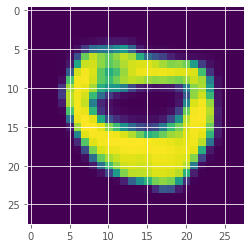

loss: 78.300194  [12800/60000]
KL_loss: 4.100870, recons_loss: 74.199333


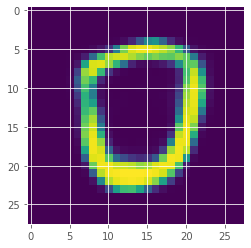

loss: 75.230133  [25600/60000]
KL_loss: 3.749429, recons_loss: 71.480705


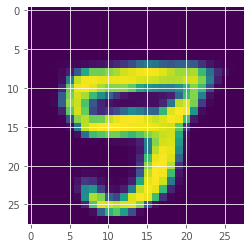

loss: 77.529839  [38400/60000]
KL_loss: 3.900961, recons_loss: 73.628868


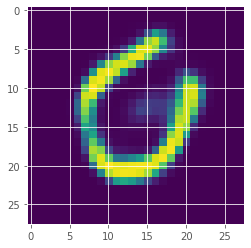

loss: 78.621887  [51200/60000]
KL_loss: 3.988785, recons_loss: 74.633110


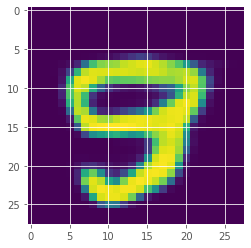

====> Average Train loss: 77.1146
====> Average Test loss: 76.5447
Validation loss decreased (76.604290 --> 76.544659).  Saving model ...
Epoch 65
-------------------------------
loss: 76.518448  [    0/60000]
KL_loss: 3.894149, recons_loss: 72.624306


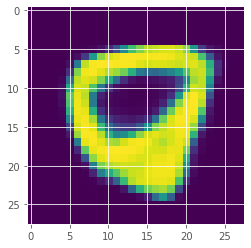

loss: 78.349541  [12800/60000]
KL_loss: 3.887378, recons_loss: 74.462158


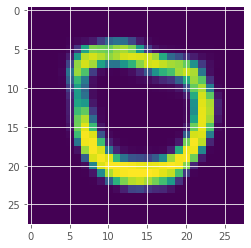

loss: 76.259506  [25600/60000]
KL_loss: 3.696156, recons_loss: 72.563324


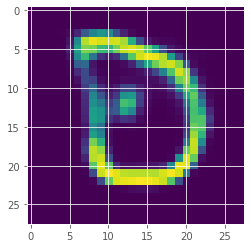

loss: 74.262833  [38400/60000]
KL_loss: 3.739415, recons_loss: 70.523415


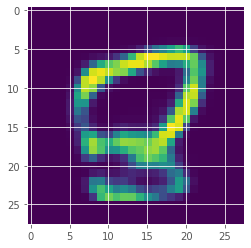

loss: 75.971039  [51200/60000]
KL_loss: 3.865130, recons_loss: 72.105904


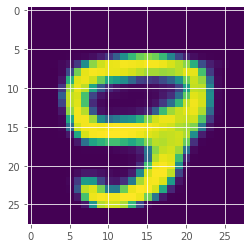

====> Average Train loss: 77.0631
====> Average Test loss: 76.4052
Validation loss decreased (76.544659 --> 76.405185).  Saving model ...
Epoch 66
-------------------------------
loss: 80.269058  [    0/60000]
KL_loss: 3.776312, recons_loss: 76.492744


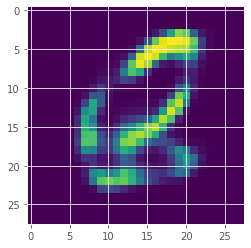

loss: 75.962997  [12800/60000]
KL_loss: 3.911183, recons_loss: 72.051811


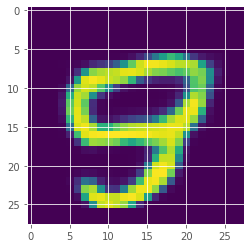

loss: 77.568695  [25600/60000]
KL_loss: 3.721422, recons_loss: 73.847282


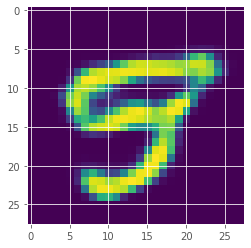

loss: 78.851006  [38400/60000]
KL_loss: 3.928952, recons_loss: 74.922066


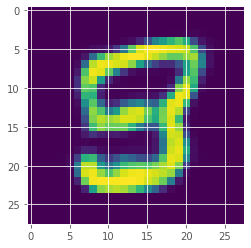

loss: 75.050514  [51200/60000]
KL_loss: 3.808991, recons_loss: 71.241524


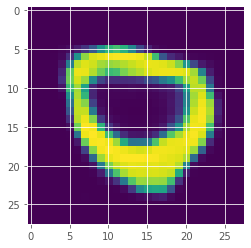

====> Average Train loss: 76.9947
====> Average Test loss: 76.5512
EarlyStopping counter: 1 out of 5
Epoch 67
-------------------------------
loss: 80.804482  [    0/60000]
KL_loss: 4.111378, recons_loss: 76.693085


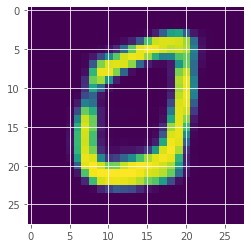

loss: 77.559532  [12800/60000]
KL_loss: 4.020769, recons_loss: 73.538773


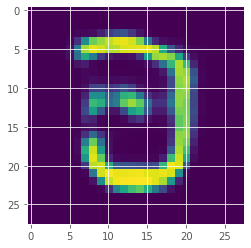

loss: 76.698517  [25600/60000]
KL_loss: 3.800230, recons_loss: 72.898285


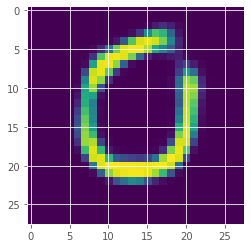

loss: 78.752792  [38400/60000]
KL_loss: 4.135492, recons_loss: 74.617287


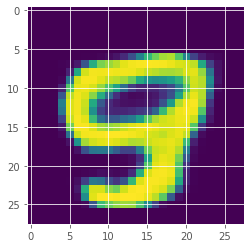

loss: 74.366013  [51200/60000]
KL_loss: 4.052633, recons_loss: 70.313385


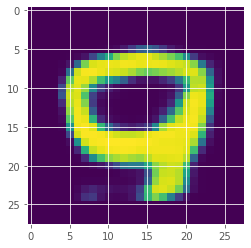

====> Average Train loss: 76.9237
====> Average Test loss: 76.4287
EarlyStopping counter: 2 out of 5
Epoch 68
-------------------------------
loss: 78.849121  [    0/60000]
KL_loss: 4.167368, recons_loss: 74.681740


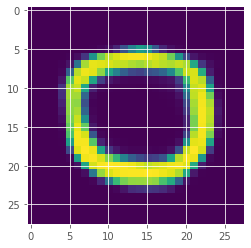

loss: 78.050301  [12800/60000]
KL_loss: 3.684663, recons_loss: 74.365631


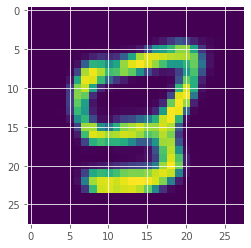

loss: 76.551460  [25600/60000]
KL_loss: 4.113339, recons_loss: 72.438126


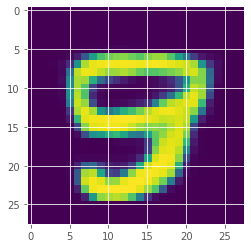

loss: 79.427002  [38400/60000]
KL_loss: 3.970423, recons_loss: 75.456581


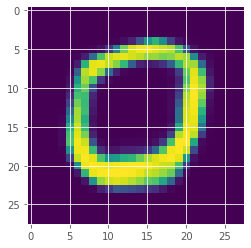

loss: 78.001900  [51200/60000]
KL_loss: 4.014052, recons_loss: 73.987839


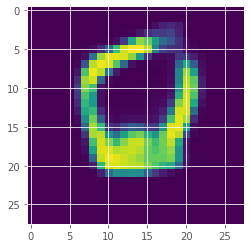

====> Average Train loss: 76.9666
====> Average Test loss: 76.2611
Validation loss decreased (76.405185 --> 76.261057).  Saving model ...
Epoch 69
-------------------------------
loss: 77.451622  [    0/60000]
KL_loss: 3.922824, recons_loss: 73.528793


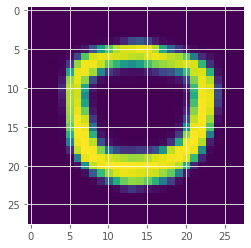

loss: 75.420189  [12800/60000]
KL_loss: 4.045884, recons_loss: 71.374321


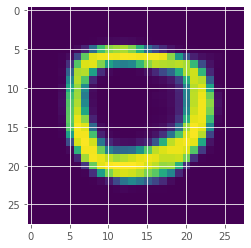

loss: 75.022697  [25600/60000]
KL_loss: 3.958437, recons_loss: 71.064262


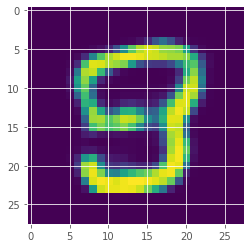

loss: 75.466042  [38400/60000]
KL_loss: 3.872336, recons_loss: 71.593712


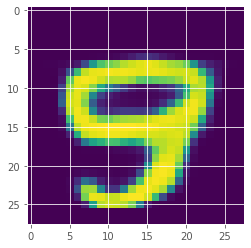

loss: 75.845871  [51200/60000]
KL_loss: 3.807823, recons_loss: 72.038063


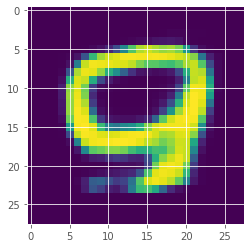

====> Average Train loss: 76.7900
====> Average Test loss: 76.1943
Validation loss decreased (76.261057 --> 76.194256).  Saving model ...
Epoch 70
-------------------------------
loss: 77.456993  [    0/60000]
KL_loss: 3.717031, recons_loss: 73.739967


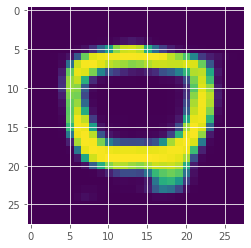

loss: 76.637306  [12800/60000]
KL_loss: 3.868791, recons_loss: 72.768494


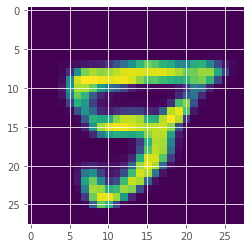

loss: 77.299629  [25600/60000]
KL_loss: 4.177982, recons_loss: 73.121666


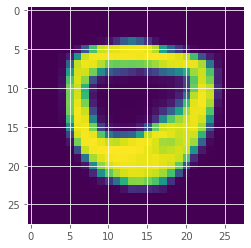

loss: 78.413467  [38400/60000]
KL_loss: 3.917122, recons_loss: 74.496353


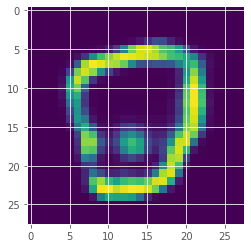

loss: 75.213097  [51200/60000]
KL_loss: 3.893482, recons_loss: 71.319618


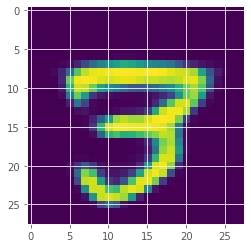

====> Average Train loss: 76.7502
====> Average Test loss: 76.2247
EarlyStopping counter: 1 out of 5
Epoch 71
-------------------------------
loss: 73.053543  [    0/60000]
KL_loss: 3.904421, recons_loss: 69.149117


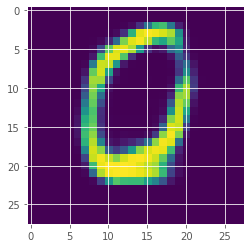

loss: 76.100121  [12800/60000]
KL_loss: 3.776037, recons_loss: 72.324059


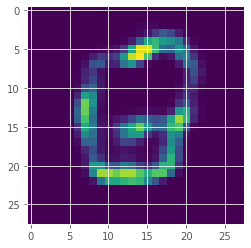

loss: 75.304459  [25600/60000]
KL_loss: 4.105906, recons_loss: 71.198555


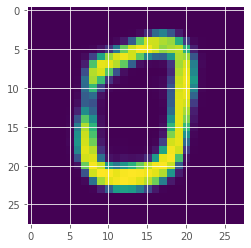

loss: 77.613899  [38400/60000]
KL_loss: 3.944473, recons_loss: 73.669434


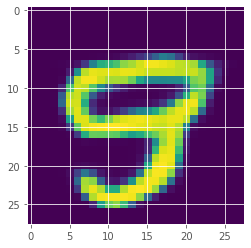

loss: 74.442032  [51200/60000]
KL_loss: 3.745647, recons_loss: 70.696365


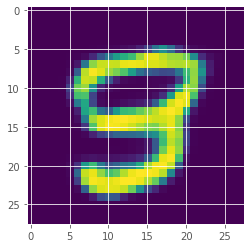

====> Average Train loss: 76.6906
====> Average Test loss: 76.1367
Validation loss decreased (76.194256 --> 76.136654).  Saving model ...
Epoch 72
-------------------------------
loss: 79.876938  [    0/60000]
KL_loss: 4.115648, recons_loss: 75.761299


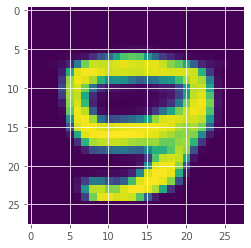

loss: 78.159660  [12800/60000]
KL_loss: 3.971822, recons_loss: 74.187828


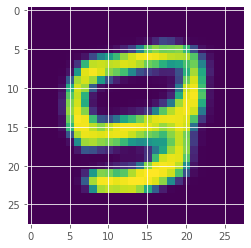

loss: 74.097420  [25600/60000]
KL_loss: 3.688932, recons_loss: 70.408485


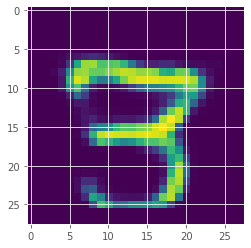

loss: 75.465370  [38400/60000]
KL_loss: 3.907122, recons_loss: 71.558250


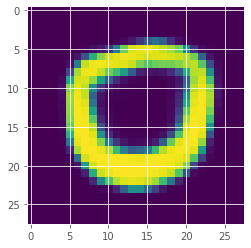

loss: 77.511856  [51200/60000]
KL_loss: 4.065658, recons_loss: 73.446198


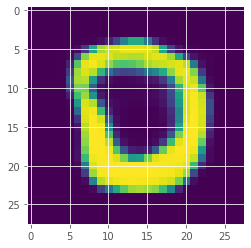

====> Average Train loss: 76.6444
====> Average Test loss: 76.0227
Validation loss decreased (76.136654 --> 76.022731).  Saving model ...
Epoch 73
-------------------------------
loss: 75.768929  [    0/60000]
KL_loss: 4.052807, recons_loss: 71.716103


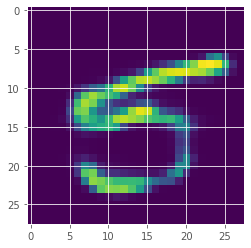

loss: 76.568169  [12800/60000]
KL_loss: 3.821541, recons_loss: 72.746635


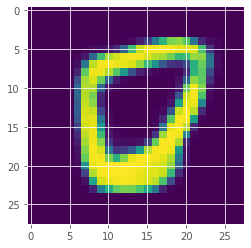

loss: 75.886848  [25600/60000]
KL_loss: 3.862510, recons_loss: 72.024338


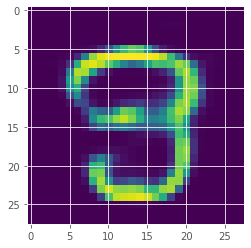

loss: 79.846336  [38400/60000]
KL_loss: 3.878427, recons_loss: 75.967903


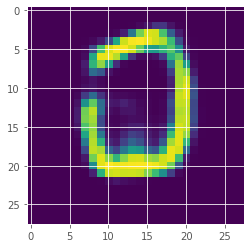

loss: 79.007408  [51200/60000]
KL_loss: 4.144144, recons_loss: 74.863258


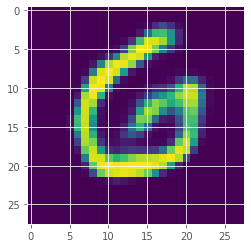

====> Average Train loss: 76.5752
====> Average Test loss: 76.0059
Validation loss decreased (76.022731 --> 76.005882).  Saving model ...
Epoch 74
-------------------------------
loss: 76.135323  [    0/60000]
KL_loss: 4.009769, recons_loss: 72.125565


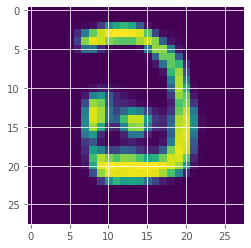

loss: 76.975616  [12800/60000]
KL_loss: 3.934403, recons_loss: 73.041214


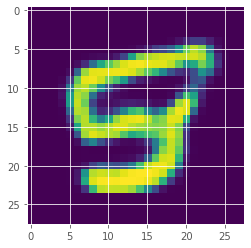

loss: 74.699196  [25600/60000]
KL_loss: 3.913855, recons_loss: 70.785324


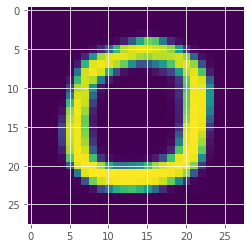

loss: 77.070610  [38400/60000]
KL_loss: 3.944698, recons_loss: 73.125908


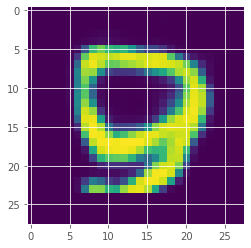

loss: 77.736595  [51200/60000]
KL_loss: 4.006192, recons_loss: 73.730392


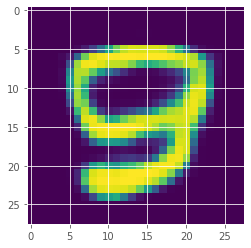

====> Average Train loss: 76.5455
====> Average Test loss: 76.0390
EarlyStopping counter: 1 out of 5
Epoch 75
-------------------------------
loss: 74.351448  [    0/60000]
KL_loss: 4.122017, recons_loss: 70.229431


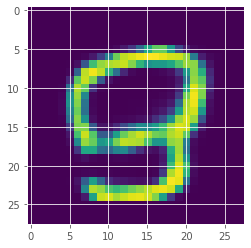

loss: 80.075241  [12800/60000]
KL_loss: 4.058897, recons_loss: 76.016342


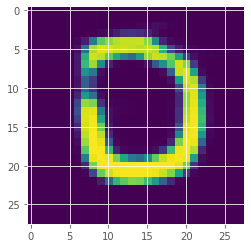

loss: 76.438683  [25600/60000]
KL_loss: 3.904980, recons_loss: 72.533691


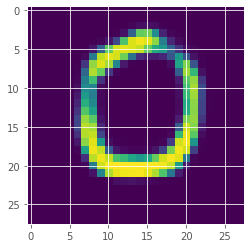

loss: 74.810974  [38400/60000]
KL_loss: 3.897860, recons_loss: 70.913132


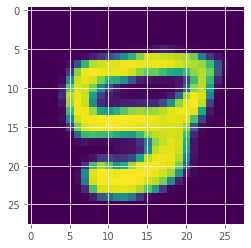

loss: 74.735931  [51200/60000]
KL_loss: 3.812922, recons_loss: 70.923019


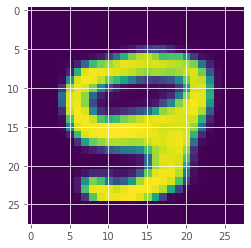

====> Average Train loss: 76.4973
====> Average Test loss: 75.9115
Validation loss decreased (76.005882 --> 75.911517).  Saving model ...
Epoch 76
-------------------------------
loss: 75.850220  [    0/60000]
KL_loss: 4.079649, recons_loss: 71.770561


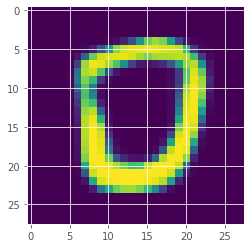

loss: 74.605576  [12800/60000]
KL_loss: 4.019610, recons_loss: 70.585968


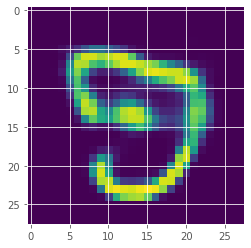

loss: 76.513512  [25600/60000]
KL_loss: 3.979279, recons_loss: 72.534241


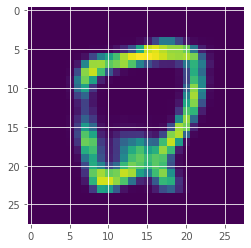

loss: 76.254555  [38400/60000]
KL_loss: 3.995735, recons_loss: 72.258812


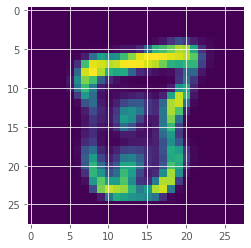

loss: 72.846992  [51200/60000]
KL_loss: 3.693635, recons_loss: 69.153358


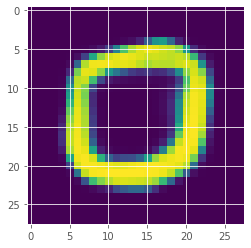

====> Average Train loss: 76.4096
====> Average Test loss: 75.8841
Validation loss decreased (75.911517 --> 75.884127).  Saving model ...
Epoch 77
-------------------------------
loss: 73.894753  [    0/60000]
KL_loss: 3.832500, recons_loss: 70.062256


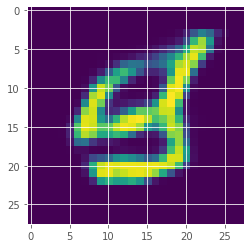

loss: 75.323441  [12800/60000]
KL_loss: 3.975718, recons_loss: 71.347733


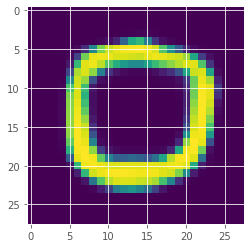

loss: 77.410873  [25600/60000]
KL_loss: 4.175778, recons_loss: 73.235085


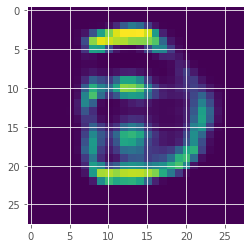

loss: 76.450882  [38400/60000]
KL_loss: 4.100194, recons_loss: 72.350677


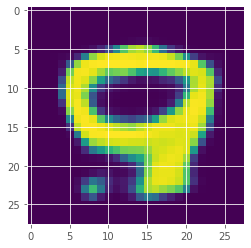

loss: 72.704956  [51200/60000]
KL_loss: 3.940187, recons_loss: 68.764763


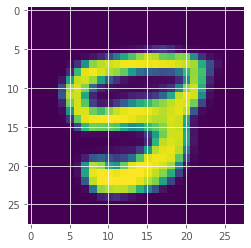

====> Average Train loss: 76.3658
====> Average Test loss: 75.8356
Validation loss decreased (75.884127 --> 75.835581).  Saving model ...
Epoch 78
-------------------------------
loss: 78.003059  [    0/60000]
KL_loss: 4.181116, recons_loss: 73.821930


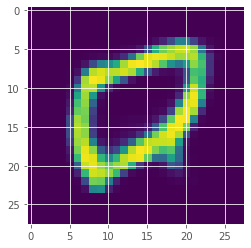

loss: 80.402885  [12800/60000]
KL_loss: 4.098073, recons_loss: 76.304817


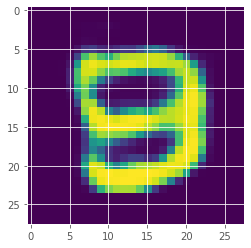

loss: 75.287598  [25600/60000]
KL_loss: 4.263652, recons_loss: 71.023941


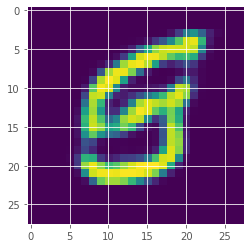

loss: 76.481606  [38400/60000]
KL_loss: 3.845448, recons_loss: 72.636162


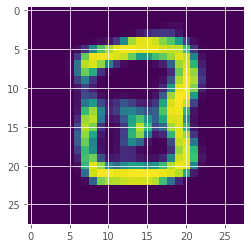

loss: 75.891144  [51200/60000]
KL_loss: 3.981305, recons_loss: 71.909836


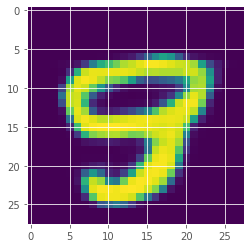

====> Average Train loss: 76.3211
====> Average Test loss: 75.7846
Validation loss decreased (75.835581 --> 75.784586).  Saving model ...
Epoch 79
-------------------------------
loss: 75.437576  [    0/60000]
KL_loss: 4.174467, recons_loss: 71.263123


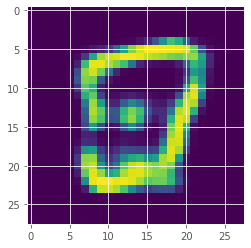

loss: 78.987236  [12800/60000]
KL_loss: 4.262791, recons_loss: 74.724449


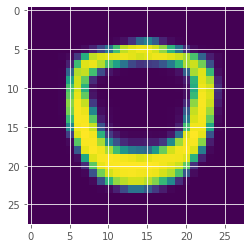

loss: 78.094803  [25600/60000]
KL_loss: 4.213087, recons_loss: 73.881721


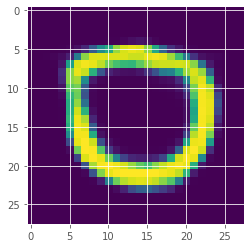

loss: 75.901291  [38400/60000]
KL_loss: 4.330406, recons_loss: 71.570900


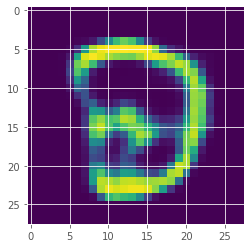

loss: 75.970543  [51200/60000]
KL_loss: 4.081268, recons_loss: 71.889275


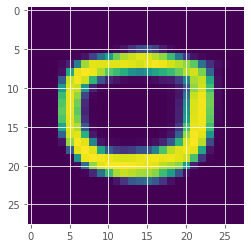

====> Average Train loss: 76.2689
====> Average Test loss: 75.7432
Validation loss decreased (75.784586 --> 75.743229).  Saving model ...
Epoch 80
-------------------------------
loss: 77.222656  [    0/60000]
KL_loss: 4.172423, recons_loss: 73.050224


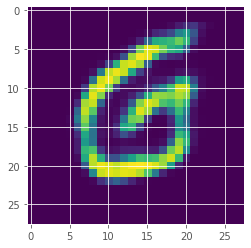

loss: 76.771233  [12800/60000]
KL_loss: 3.890880, recons_loss: 72.880341


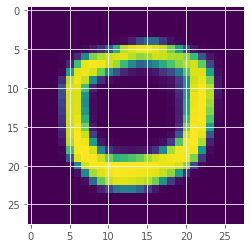

loss: 76.765167  [25600/60000]
KL_loss: 4.089887, recons_loss: 72.675285


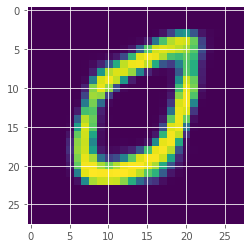

loss: 75.827797  [38400/60000]
KL_loss: 4.261001, recons_loss: 71.566811


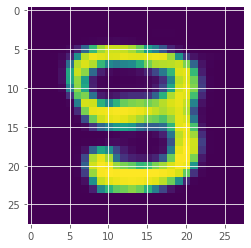

loss: 78.097717  [51200/60000]
KL_loss: 4.108336, recons_loss: 73.989372


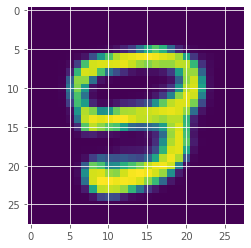

====> Average Train loss: 76.2264
====> Average Test loss: 75.7054
Validation loss decreased (75.743229 --> 75.705370).  Saving model ...
Epoch 81
-------------------------------
loss: 76.850723  [    0/60000]
KL_loss: 3.964528, recons_loss: 72.886185


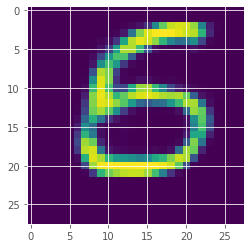

loss: 76.604576  [12800/60000]
KL_loss: 4.120104, recons_loss: 72.484474


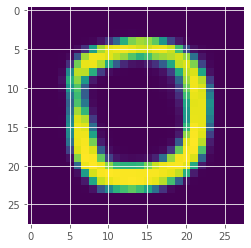

loss: 74.563194  [25600/60000]
KL_loss: 3.847954, recons_loss: 70.715240


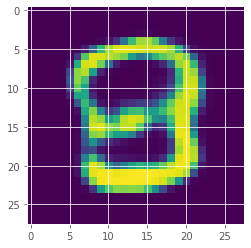

loss: 78.552345  [38400/60000]
KL_loss: 4.484030, recons_loss: 74.068314


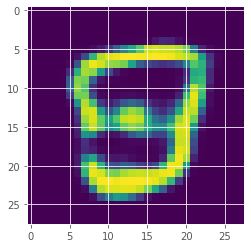

loss: 76.847603  [51200/60000]
KL_loss: 3.976156, recons_loss: 72.871437


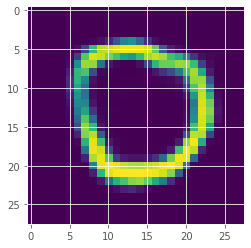

====> Average Train loss: 76.1703
====> Average Test loss: 75.6046
Validation loss decreased (75.705370 --> 75.604556).  Saving model ...
Epoch 82
-------------------------------
loss: 77.630394  [    0/60000]
KL_loss: 4.213210, recons_loss: 73.417175


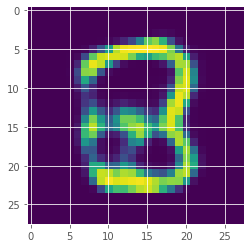

loss: 76.741249  [12800/60000]
KL_loss: 4.342657, recons_loss: 72.398590


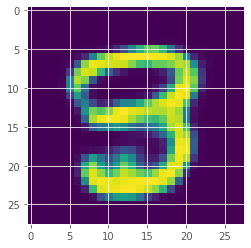

loss: 75.455902  [25600/60000]
KL_loss: 3.992737, recons_loss: 71.463173


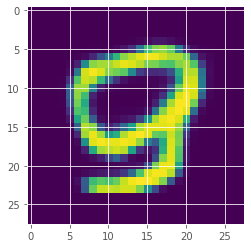

loss: 76.622566  [38400/60000]
KL_loss: 4.237299, recons_loss: 72.385262


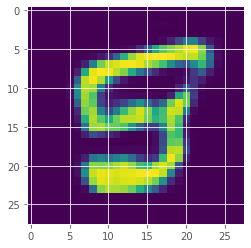

loss: 73.511917  [51200/60000]
KL_loss: 3.986369, recons_loss: 69.525551


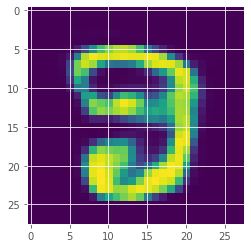

====> Average Train loss: 76.1304
====> Average Test loss: 75.5546
Validation loss decreased (75.604556 --> 75.554605).  Saving model ...
Epoch 83
-------------------------------
loss: 74.388947  [    0/60000]
KL_loss: 4.152697, recons_loss: 70.236252


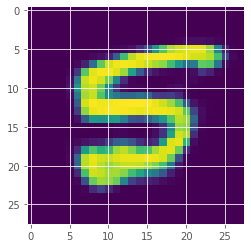

loss: 74.574066  [12800/60000]
KL_loss: 4.137019, recons_loss: 70.437057


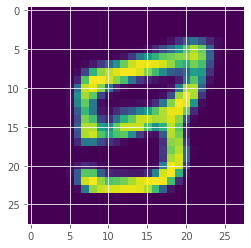

loss: 77.576958  [25600/60000]
KL_loss: 4.074472, recons_loss: 73.502495


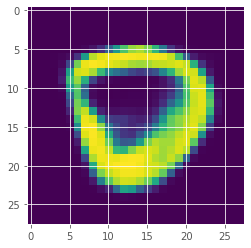

loss: 75.868011  [38400/60000]
KL_loss: 4.045607, recons_loss: 71.822411


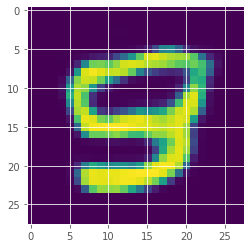

loss: 73.894768  [51200/60000]
KL_loss: 4.126425, recons_loss: 69.768333


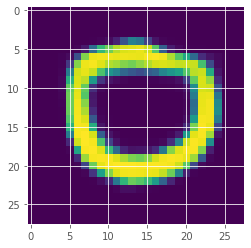

====> Average Train loss: 76.0726
====> Average Test loss: 75.5476
Validation loss decreased (75.554605 --> 75.547581).  Saving model ...
Epoch 84
-------------------------------
loss: 74.834885  [    0/60000]
KL_loss: 4.022643, recons_loss: 70.812256


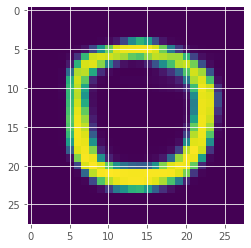

loss: 76.831726  [12800/60000]
KL_loss: 4.292220, recons_loss: 72.539520


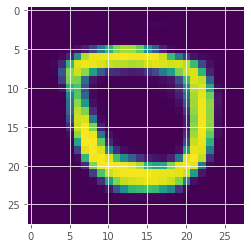

loss: 75.122902  [25600/60000]
KL_loss: 3.951631, recons_loss: 71.171288


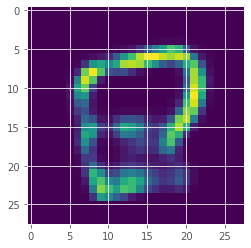

loss: 74.880608  [38400/60000]
KL_loss: 4.248311, recons_loss: 70.632286


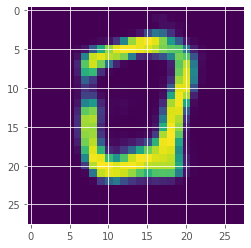

loss: 74.854782  [51200/60000]
KL_loss: 3.962907, recons_loss: 70.891869


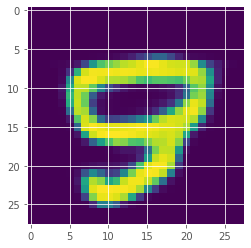

====> Average Train loss: 76.0074
====> Average Test loss: 75.4822
Validation loss decreased (75.547581 --> 75.482202).  Saving model ...
Epoch 85
-------------------------------
loss: 73.685577  [    0/60000]
KL_loss: 4.055969, recons_loss: 69.629601


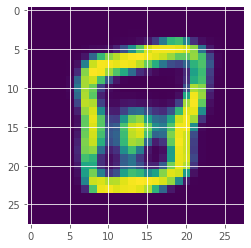

loss: 77.067719  [12800/60000]
KL_loss: 4.036565, recons_loss: 73.031158


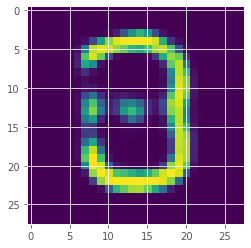

loss: 78.788872  [25600/60000]
KL_loss: 4.245512, recons_loss: 74.543350


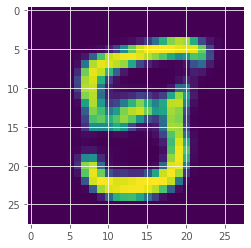

loss: 75.852242  [38400/60000]
KL_loss: 4.003380, recons_loss: 71.848854


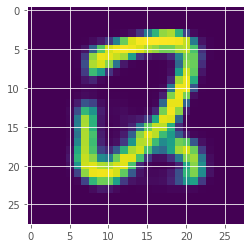

loss: 75.479057  [51200/60000]
KL_loss: 4.173014, recons_loss: 71.306030


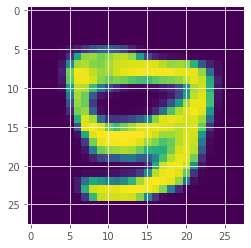

====> Average Train loss: 75.9759
====> Average Test loss: 75.4695
Validation loss decreased (75.482202 --> 75.469488).  Saving model ...
Epoch 86
-------------------------------
loss: 75.525505  [    0/60000]
KL_loss: 4.250613, recons_loss: 71.274887


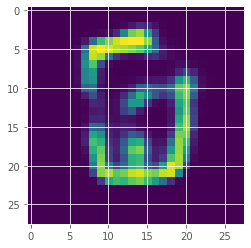

loss: 77.591957  [12800/60000]
KL_loss: 4.077681, recons_loss: 73.514282


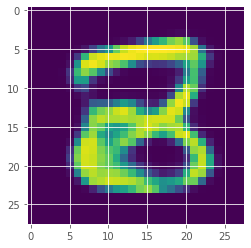

loss: 76.527229  [25600/60000]
KL_loss: 4.358268, recons_loss: 72.168961


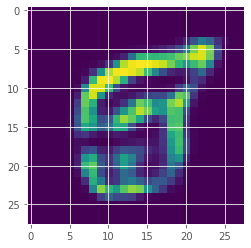

loss: 76.057930  [38400/60000]
KL_loss: 4.052619, recons_loss: 72.005310


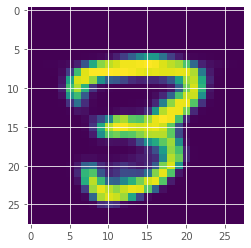

loss: 73.286041  [51200/60000]
KL_loss: 4.158612, recons_loss: 69.127434


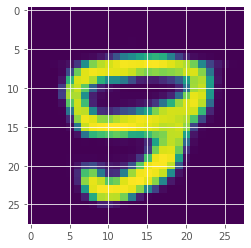

====> Average Train loss: 75.9464
====> Average Test loss: 75.3164
Validation loss decreased (75.469488 --> 75.316356).  Saving model ...
Epoch 87
-------------------------------
loss: 73.150192  [    0/60000]
KL_loss: 4.187495, recons_loss: 68.962700


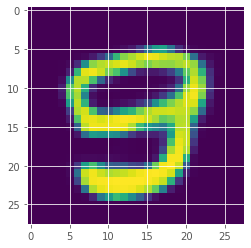

loss: 77.661324  [12800/60000]
KL_loss: 4.245761, recons_loss: 73.415558


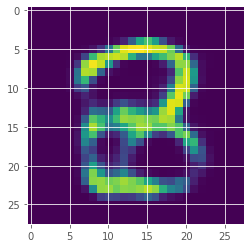

loss: 73.762772  [25600/60000]
KL_loss: 4.173501, recons_loss: 69.589279


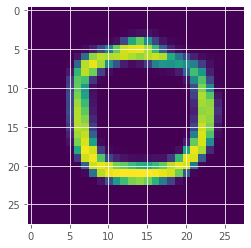

loss: 77.747566  [38400/60000]
KL_loss: 3.996510, recons_loss: 73.751060


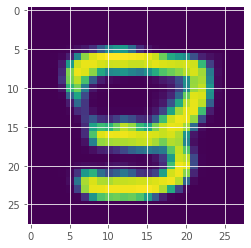

loss: 76.264084  [51200/60000]
KL_loss: 4.322583, recons_loss: 71.941490


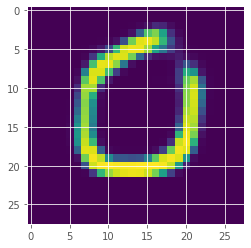

====> Average Train loss: 75.9055
====> Average Test loss: 75.5157
EarlyStopping counter: 1 out of 5
Epoch 88
-------------------------------
loss: 73.387840  [    0/60000]
KL_loss: 4.043823, recons_loss: 69.344009


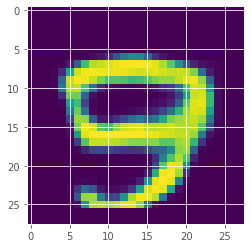

loss: 78.078621  [12800/60000]
KL_loss: 4.412633, recons_loss: 73.665985


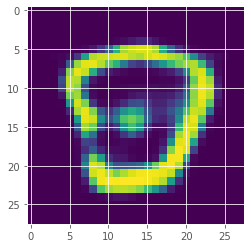

loss: 76.350311  [25600/60000]
KL_loss: 4.370095, recons_loss: 71.980217


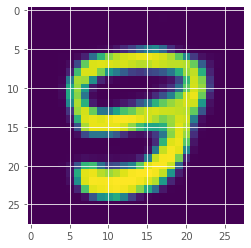

loss: 78.686562  [38400/60000]
KL_loss: 4.294442, recons_loss: 74.392113


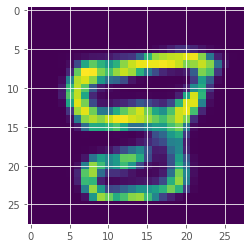

loss: 74.511360  [51200/60000]
KL_loss: 4.014589, recons_loss: 70.496750


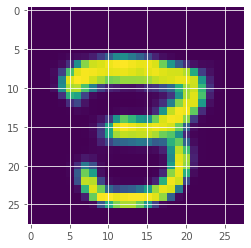

====> Average Train loss: 75.8513
====> Average Test loss: 75.3554
EarlyStopping counter: 2 out of 5
Epoch 89
-------------------------------
loss: 75.495262  [    0/60000]
KL_loss: 4.135670, recons_loss: 71.359581


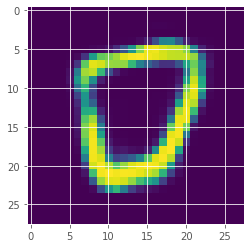

loss: 75.472328  [12800/60000]
KL_loss: 4.116336, recons_loss: 71.355995


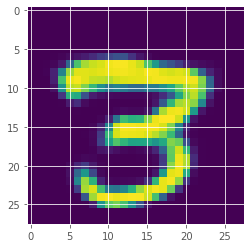

loss: 76.470352  [25600/60000]
KL_loss: 4.151245, recons_loss: 72.319099


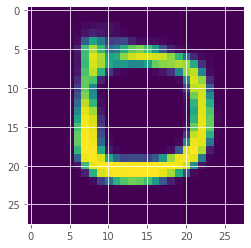

loss: 73.497742  [38400/60000]
KL_loss: 4.132493, recons_loss: 69.365219


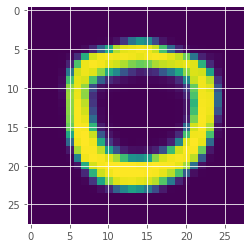

loss: 75.479958  [51200/60000]
KL_loss: 4.347634, recons_loss: 71.132332


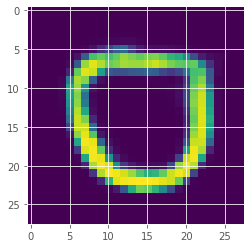

====> Average Train loss: 75.8238
====> Average Test loss: 75.2585
Validation loss decreased (75.316356 --> 75.258484).  Saving model ...
Epoch 90
-------------------------------
loss: 76.205872  [    0/60000]
KL_loss: 3.871305, recons_loss: 72.334564


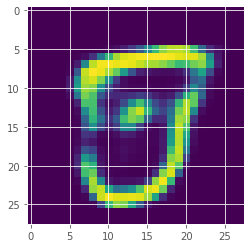

loss: 76.198860  [12800/60000]
KL_loss: 4.229918, recons_loss: 71.968941


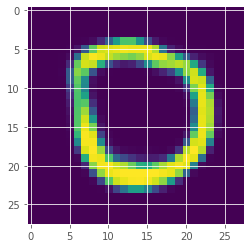

loss: 78.840660  [25600/60000]
KL_loss: 4.442444, recons_loss: 74.398209


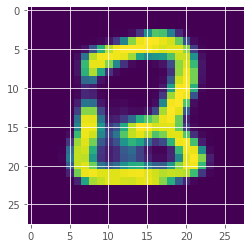

loss: 75.562416  [38400/60000]
KL_loss: 4.305695, recons_loss: 71.256721


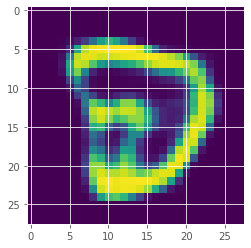

loss: 76.084030  [51200/60000]
KL_loss: 4.096683, recons_loss: 71.987358


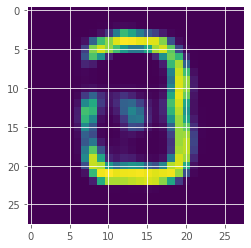

====> Average Train loss: 75.7776
====> Average Test loss: 75.1951
Validation loss decreased (75.258484 --> 75.195066).  Saving model ...
Epoch 91
-------------------------------
loss: 76.490173  [    0/60000]
KL_loss: 4.358502, recons_loss: 72.131683


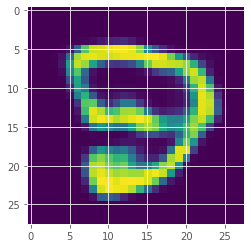

loss: 74.930664  [12800/60000]
KL_loss: 4.102036, recons_loss: 70.828621


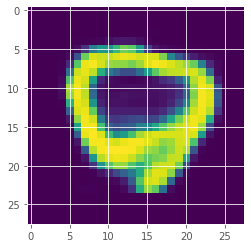

loss: 78.059181  [25600/60000]
KL_loss: 4.316671, recons_loss: 73.742493


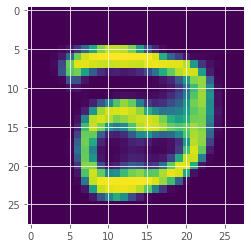

loss: 75.854752  [38400/60000]
KL_loss: 4.213507, recons_loss: 71.641243


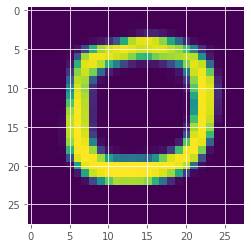

loss: 77.550972  [51200/60000]
KL_loss: 4.285428, recons_loss: 73.265549


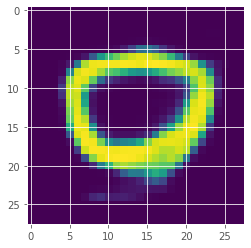

====> Average Train loss: 75.7407
====> Average Test loss: 75.2557
EarlyStopping counter: 1 out of 5
Epoch 92
-------------------------------
loss: 72.199455  [    0/60000]
KL_loss: 4.039363, recons_loss: 68.160095


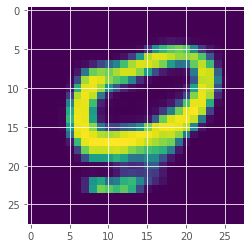

loss: 74.152962  [12800/60000]
KL_loss: 4.270713, recons_loss: 69.882248


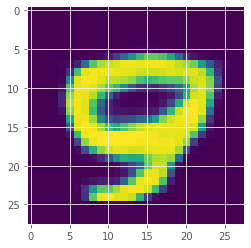

loss: 78.548630  [25600/60000]
KL_loss: 4.198524, recons_loss: 74.350098


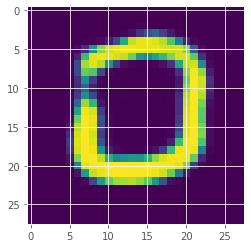

loss: 74.715446  [38400/60000]
KL_loss: 3.959289, recons_loss: 70.756157


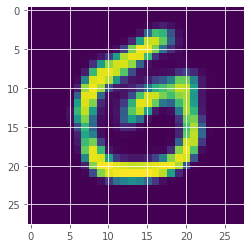

loss: 76.428871  [51200/60000]
KL_loss: 4.248487, recons_loss: 72.180367


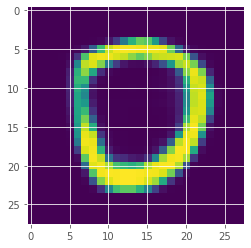

====> Average Train loss: 75.6805
====> Average Test loss: 75.1760
Validation loss decreased (75.195066 --> 75.176017).  Saving model ...
Epoch 93
-------------------------------
loss: 71.442543  [    0/60000]
KL_loss: 3.979261, recons_loss: 67.463295


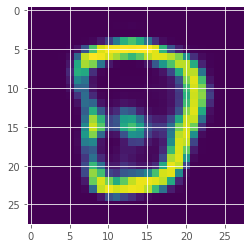

loss: 77.632736  [12800/60000]
KL_loss: 4.089528, recons_loss: 73.543213


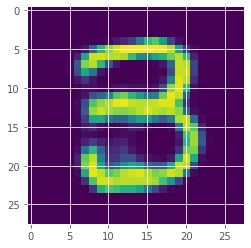

loss: 74.041603  [25600/60000]
KL_loss: 4.243395, recons_loss: 69.798195


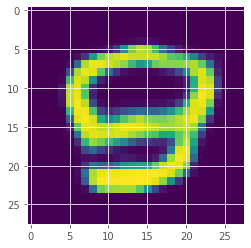

loss: 73.910606  [38400/60000]
KL_loss: 3.956310, recons_loss: 69.954308


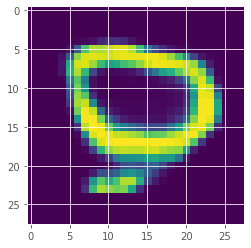

loss: 76.679138  [51200/60000]
KL_loss: 4.241910, recons_loss: 72.437225


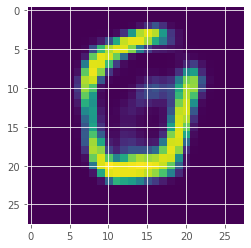

====> Average Train loss: 75.6675
====> Average Test loss: 75.0851
Validation loss decreased (75.176017 --> 75.085141).  Saving model ...
Epoch 94
-------------------------------
loss: 79.315636  [    0/60000]
KL_loss: 4.342035, recons_loss: 74.973595


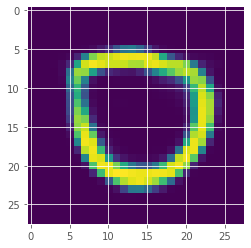

loss: 75.596855  [12800/60000]
KL_loss: 4.524827, recons_loss: 71.072044


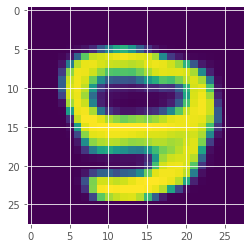

loss: 75.461815  [25600/60000]
KL_loss: 4.129733, recons_loss: 71.332092


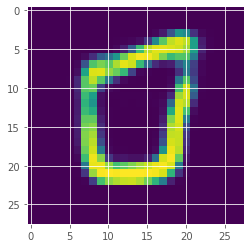

loss: 76.081100  [38400/60000]
KL_loss: 4.238740, recons_loss: 71.842369


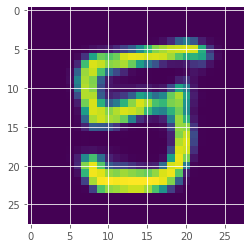

loss: 75.054848  [51200/60000]
KL_loss: 4.318022, recons_loss: 70.736816


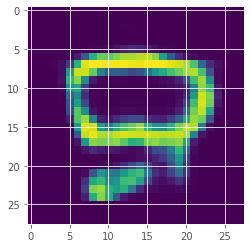

====> Average Train loss: 75.6053
====> Average Test loss: 75.1610
EarlyStopping counter: 1 out of 5
Epoch 95
-------------------------------
loss: 74.698151  [    0/60000]
KL_loss: 3.905483, recons_loss: 70.792679


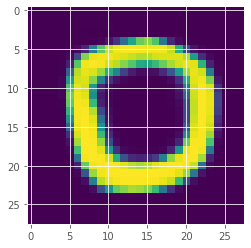

loss: 75.208862  [12800/60000]
KL_loss: 4.384171, recons_loss: 70.824699


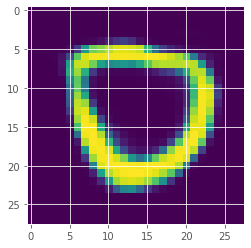

loss: 77.772240  [25600/60000]
KL_loss: 4.516778, recons_loss: 73.255463


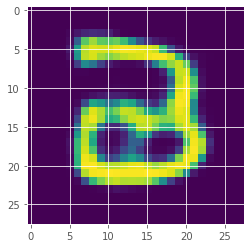

loss: 74.517448  [38400/60000]
KL_loss: 4.125278, recons_loss: 70.392159


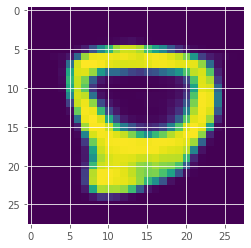

loss: 71.574623  [51200/60000]
KL_loss: 3.901415, recons_loss: 67.673203


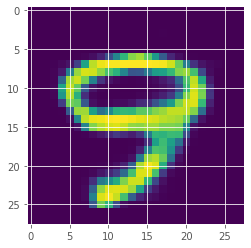

====> Average Train loss: 75.5922
====> Average Test loss: 75.0736
Validation loss decreased (75.085141 --> 75.073572).  Saving model ...
Epoch 96
-------------------------------
loss: 72.566223  [    0/60000]
KL_loss: 4.036784, recons_loss: 68.529442


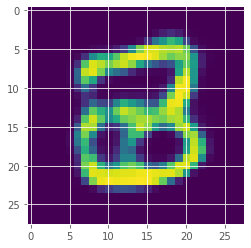

loss: 73.458038  [12800/60000]
KL_loss: 4.142456, recons_loss: 69.315590


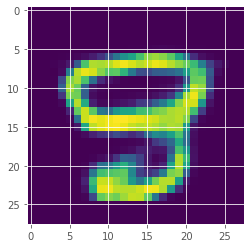

loss: 77.029152  [25600/60000]
KL_loss: 4.127190, recons_loss: 72.901955


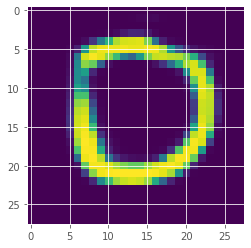

loss: 72.892899  [38400/60000]
KL_loss: 4.134234, recons_loss: 68.758675


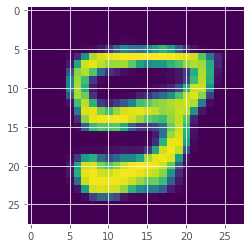

loss: 72.451523  [51200/60000]
KL_loss: 3.823785, recons_loss: 68.627747


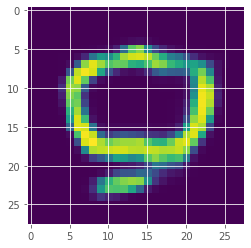

====> Average Train loss: 75.5254
====> Average Test loss: 75.0278
Validation loss decreased (75.073572 --> 75.027835).  Saving model ...
Epoch 97
-------------------------------
loss: 75.684998  [    0/60000]
KL_loss: 4.312987, recons_loss: 71.372017


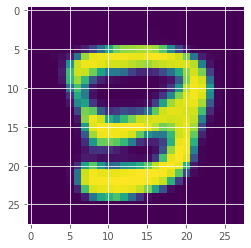

loss: 78.583389  [12800/60000]
KL_loss: 4.147452, recons_loss: 74.435928


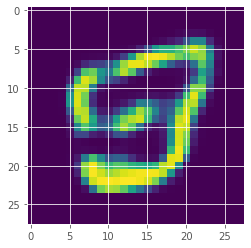

loss: 76.597382  [25600/60000]
KL_loss: 4.497119, recons_loss: 72.100258


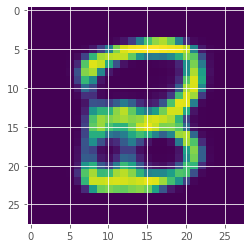

loss: 77.617470  [38400/60000]
KL_loss: 4.154703, recons_loss: 73.462769


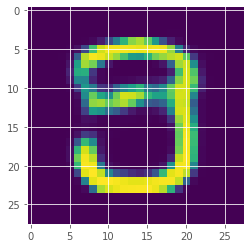

loss: 76.157104  [51200/60000]
KL_loss: 4.180439, recons_loss: 71.976662


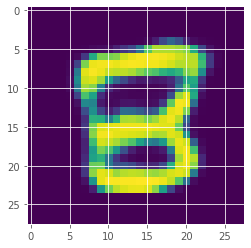

====> Average Train loss: 75.5136
====> Average Test loss: 75.0118
Validation loss decreased (75.027835 --> 75.011778).  Saving model ...
Epoch 98
-------------------------------
loss: 75.870628  [    0/60000]
KL_loss: 4.113250, recons_loss: 71.757378


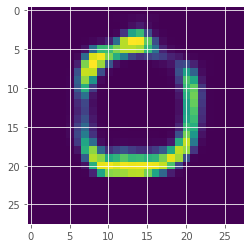

loss: 76.413940  [12800/60000]
KL_loss: 4.222747, recons_loss: 72.191200


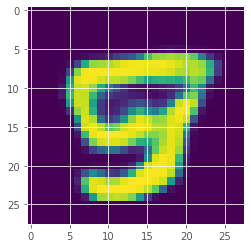

loss: 75.933456  [25600/60000]
KL_loss: 4.265738, recons_loss: 71.667725


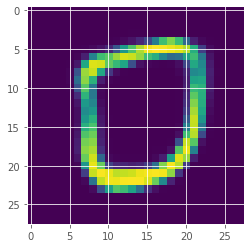

loss: 73.627731  [38400/60000]
KL_loss: 4.063297, recons_loss: 69.564438


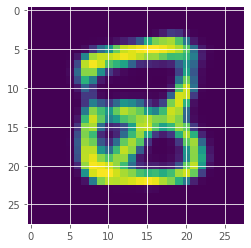

loss: 74.653999  [51200/60000]
KL_loss: 4.042530, recons_loss: 70.611458


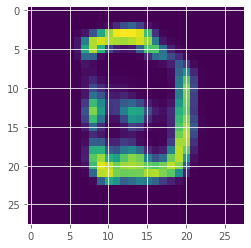

====> Average Train loss: 75.4967
====> Average Test loss: 75.0450
EarlyStopping counter: 1 out of 5
Epoch 99
-------------------------------
loss: 70.903252  [    0/60000]
KL_loss: 4.022028, recons_loss: 66.881248


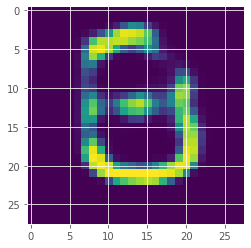

loss: 73.855850  [12800/60000]
KL_loss: 4.184994, recons_loss: 69.670853


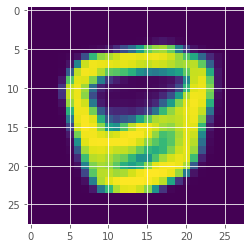

loss: 74.304802  [25600/60000]
KL_loss: 4.017359, recons_loss: 70.287445


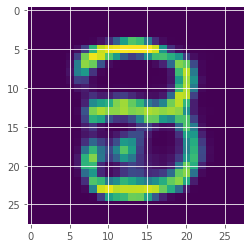

loss: 76.077194  [38400/60000]
KL_loss: 4.280263, recons_loss: 71.796928


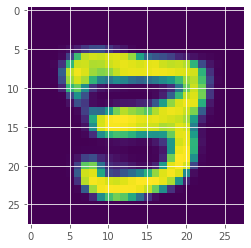

loss: 76.573868  [51200/60000]
KL_loss: 4.341630, recons_loss: 72.232239


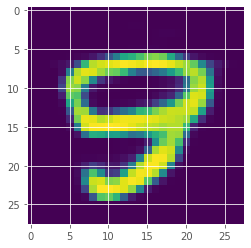

====> Average Train loss: 75.4398
====> Average Test loss: 74.9647
Validation loss decreased (75.011778 --> 74.964679).  Saving model ...
Epoch 100
-------------------------------
loss: 74.794693  [    0/60000]
KL_loss: 3.859641, recons_loss: 70.935059


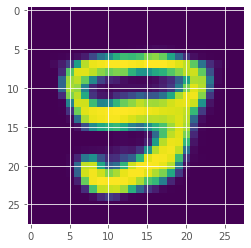

loss: 78.290047  [12800/60000]
KL_loss: 4.320942, recons_loss: 73.969109


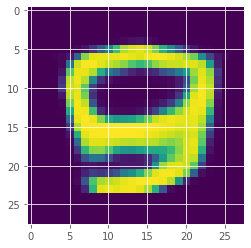

loss: 75.022873  [25600/60000]
KL_loss: 4.310281, recons_loss: 70.712601


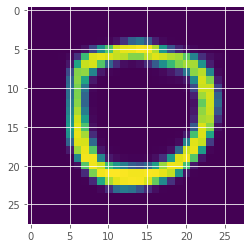

loss: 74.437599  [38400/60000]
KL_loss: 4.167636, recons_loss: 70.269951


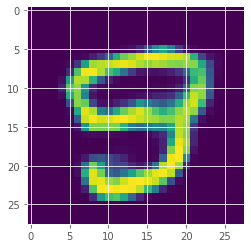

loss: 74.358444  [51200/60000]
KL_loss: 4.059894, recons_loss: 70.298553


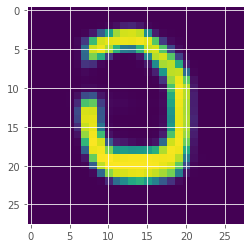

====> Average Train loss: 75.4224
====> Average Test loss: 74.9323
Validation loss decreased (74.964679 --> 74.932295).  Saving model ...
Execution complete


In [34]:
def main():
    
    # set the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    # instantiate the config class and set up the seeds    
    conf = Config()
    set_all_seeds(123)

    # set up the data loaders
    train_dataloader, test_dataloader = load_dataset(conf.batch_size)

    # instantiate the model and set up the optimizer    
    model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
    #model= nn.DataParallel(model, device_ids = conf.device_ids)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = conf.learning_rate)

    # run model
    model, train_loss, test_loss = execute(model, train_dataloader, test_dataloader, conf, device)
    return model, train_loss, test_loss

In [ ]:
model, train_loss, test_loss = main()

In [35]:
torch.cuda.memory_allocated()

49804288

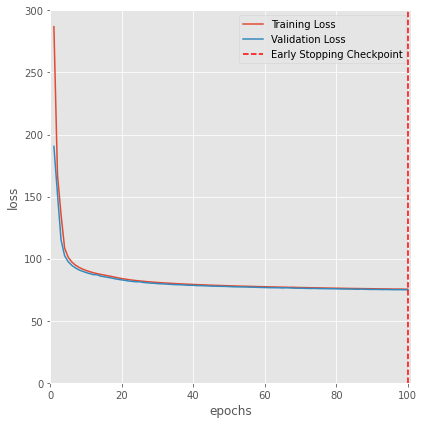

In [37]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(6,6))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 300) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [20]:
# set the device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
  
# instantiate the config class and set up the seeds    
conf = Config()
set_all_seeds(123)

In [38]:
state_dict = torch.load('saves/checkpoint3.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
model = model.to(device)
model.load_state_dict(state_dict)


<All keys matched successfully>

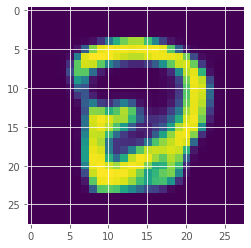

In [53]:
# generating samples from prior distribution
sample = model.sample(28, device)
plt.imshow(sample.cpu().detach().numpy())
plt.show()

In [3]:
train_dataloader, test_dataloader = load_dataset(conf.batch_size)

NameError: name 'load_dataset' is not defined

In [117]:
# for getting the desired length subset of the dataset
#test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, 50))

In [1]:
def get_data(data_loader):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    #print(images.size())  # ---> torch.Size([128, 1, 28, 28]) # batch_size number of images
    #print(images[0].size()) # ---> torch.Size([1, 28, 28])     # images[0] is the image at index 0 in the given batch
    #print(images[0].squeeze(0).size())  # ---> torch.Size([28, 28])
    return images, labels

In [ ]:
images, labels = get_data(train_dataloader)
#images, labels = get_data(test_dataloader)

In [63]:
index = 112  # ranges from 0 to batch_size
x = images[index].squeeze(0)
x = x.to(device)
print("This image is of digit: ",labels[index].numpy())

This image is of digit:  8


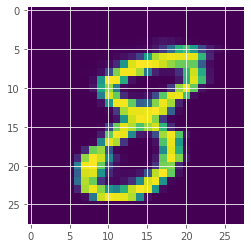

In [64]:
def show(x):
    reconstructed_image = model.reconstruction_from_posterior(x)
    plt.imshow(reconstructed_image.cpu().detach().numpy())
    plt.show()
    
show(x)

In [2]:
#images, labels = get_data(train_dataloader)
images, labels = get_data(test_dataloader)

NameError: name 'test_dataloader' is not defined

In [ ]:
index = 112  # ranges from 0 to batch_size
x = images[index].squeeze(0)
x = x.to(device)
print("This image is of digit: ",labels[index].numpy())

In [ ]:
def show(x):
    reconstructed_image = model.reconstruction_from_posterior(x)
    plt.imshow(reconstructed_image.cpu().detach().numpy())
    plt.show()
    
show(x)

In [ ]:
encoded_samples = []
z_array = []

subset_len = 5
test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, subset_len))

for data in test_set:
    # img has dimensions (1,28,28)
    img = data[0].squeeze().to(device)   # --> has dimensions (28,28)
    label = data[1]
    #print(img.size())     # --> has dimensions (28, 28)
    #print(img.unsqueeze(0).size())  # --> dimensions = (1,28,28)
    #print(img[i].size())   # --> has dimensions (28,)
    #print(img[i].unsqueeze(0).size())  # --> has dimensions (1,28)

    # encode img
    model.eval()
    with torch.no_grad():
        z = model.encode(img)
        
    # append to the list
    z = z.cpu().detach().numpy()
    print(z[-1])
    break
    '''
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(z[-1])}
    encoded_sample['label'] = label
    z_array.append(z[-1])
    encoded_samples.append(encoded_sample)
    '''

In [ ]:
len(z_array)

In [ ]:
z_array[0:5]

In [ ]:
z_array = np.array(z_array)

In [ ]:
z_array.shape

In [ ]:
z_array = z_array.squeeze(1)
z_array.shape

In [ ]:
z_array[0:5]

In [ ]:
encoded_samples = pd.DataFrame(encoded_samples)

In [ ]:
encoded_samples.head()

In [ ]:
encoded_samples['Enc. Variable 0'][0]

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2)
#tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
tsne_results = tsne.fit_transform(z_array)

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()